### Lab 2 | Handwritten Digit Recognition System

Problem Statement
- Developing a handwritten digital recognition system by creating a neural network model trained on MNIST dataset "handwritten digits from 0 to 9"

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Loading Dataset

In [103]:
train_data = pd.read_csv("/content/mnist_train.csv")
test_data = pd.read_csv("/content/mnist_test.csv")
print(train_data.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


### Data Split

In [104]:
X_temp = train_data.iloc[:,1:].values
y_temp = train_data.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [105]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50000
Validation set size: 10000
Test set size: 10000


### Normalization

In [106]:
X_test = X_test / 255.0
X_train = X_train / 255.0
X_val = X_val / 255.0

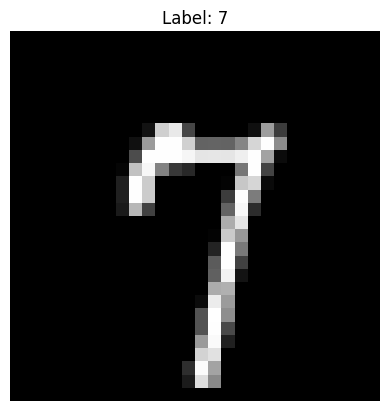

In [107]:
sample_image = X_train[0]
sample_label = y_train[0]
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### Tensors

In [108]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### Loaders for batches usage

In [109]:
batch_size = 32

# Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Neural Network Design

In [110]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()

        # Neurons number assumed: 128 then 64
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


### Neural Network Creation

In [111]:
model = FeedforwardNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training

In [112]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):

      # Training Loss and Accuracy
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct / total

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation Loss and Accuracy
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      for inputs, labels in val_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * val_correct / val_total

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{epochs}]')
      print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
      print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

  # Plot the training loss
  plt.figure(figsize=(12, 10))

  # Plot loss
  plt.subplot(2, 2, 1)  # Training Loss
  plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)  # Validation Loss
  plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plot accuracy
  plt.subplot(2, 2, 3)  # Training Accuracy
  plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(2, 2, 4)  # Validation Accuracy
  plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  # Show the plots
  plt.tight_layout()
  plt.show()

Epoch [1/10]
Training Loss: 1.3178, Accuracy: 63.30%
Validation Loss: 0.5068, Accuracy: 85.78%
Epoch [2/10]
Training Loss: 0.3936, Accuracy: 88.91%
Validation Loss: 0.3434, Accuracy: 90.27%
Epoch [3/10]
Training Loss: 0.3137, Accuracy: 91.00%
Validation Loss: 0.2953, Accuracy: 91.62%
Epoch [4/10]
Training Loss: 0.2754, Accuracy: 92.09%
Validation Loss: 0.2631, Accuracy: 92.41%
Epoch [5/10]
Training Loss: 0.2457, Accuracy: 92.98%
Validation Loss: 0.2365, Accuracy: 93.21%
Epoch [6/10]
Training Loss: 0.2201, Accuracy: 93.64%
Validation Loss: 0.2140, Accuracy: 93.91%
Epoch [7/10]
Training Loss: 0.1981, Accuracy: 94.21%
Validation Loss: 0.1941, Accuracy: 94.55%
Epoch [8/10]
Training Loss: 0.1795, Accuracy: 94.78%
Validation Loss: 0.1771, Accuracy: 95.01%
Epoch [9/10]
Training Loss: 0.1633, Accuracy: 95.33%
Validation Loss: 0.1623, Accuracy: 95.45%
Epoch [10/10]
Training Loss: 0.1498, Accuracy: 95.68%
Validation Loss: 0.1494, Accuracy: 95.82%


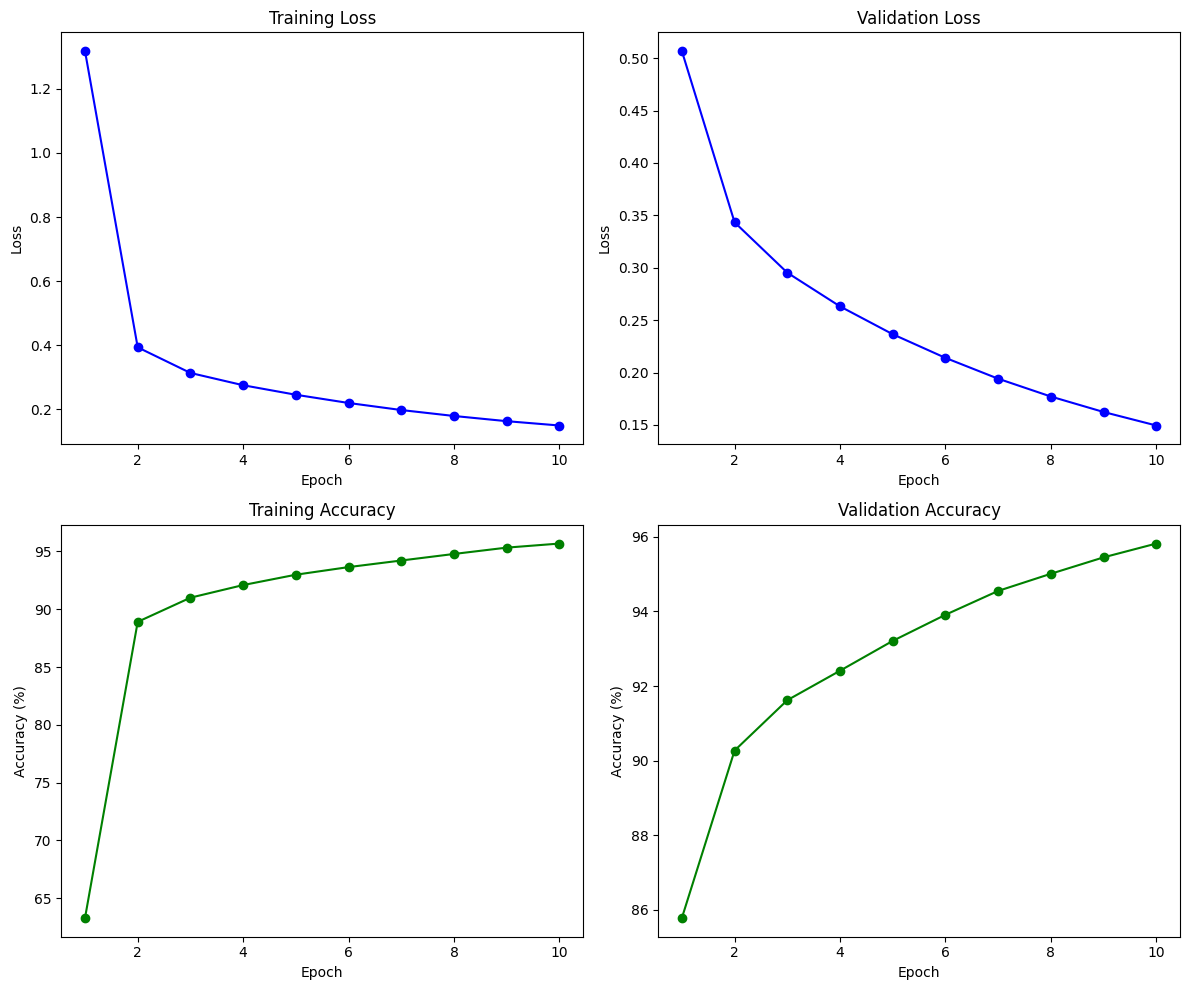

In [113]:
train(model, train_loader, val_loader, loss_fn, optimizer, 10)

# Testing

In [114]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  # Lists to store all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Reshape inputs if necessary (e.g., for flattened images)
          inputs = inputs.view(inputs.size(0), -1)  # Automatically handle batch size
          outputs = model(inputs)

          # Get predicted labels
          _, predicted = torch.max(outputs, dim=1)

          # Update metrics
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store predictions and true labels
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate overall accuracy
  test_accuracy = 100 * correct / total
  print(f"Test Accuracy: {test_accuracy:.2f}%")

  # Generate confusion matrix
  cm = confusion_matrix(all_labels, all_preds)

  # Plot the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  # Visualize multiple sample predictions
  sample_indices = [0,1,2,3,4,5]

  num_samples = len(sample_indices)
  plt.figure(figsize=(12, 3 * num_samples))

  for i, index in enumerate(sample_indices):
      sample_image = X_test[index]
      true_label = y_test[index]

      # Prepare the sample for the model
      sample_image = torch.tensor(sample_image).float().view(1, -1) / 255.0

      with torch.no_grad():
          output = model(sample_image)
          _, predicted_label = torch.max(output, 1)

      # Plot the image
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(sample_image.reshape(28, 28), cmap='gray')
      plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

Test Accuracy: 95.55%


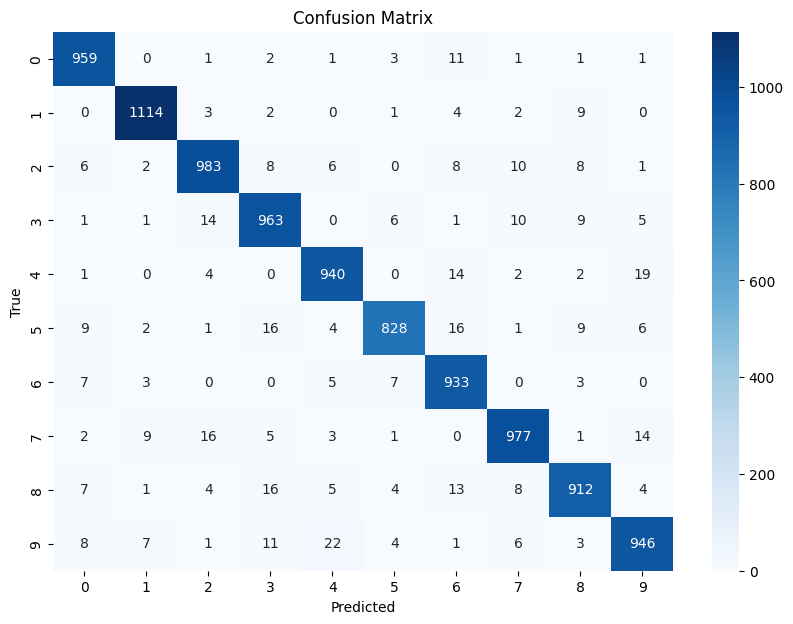

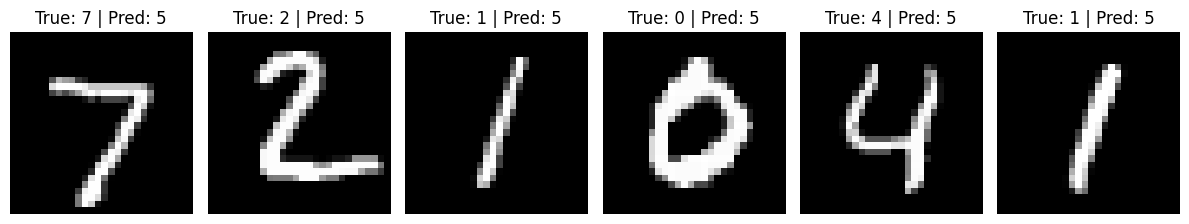

In [115]:
test(model, test_loader)

# **Analysis**

# Change Learning Rate [0.1, 0.05, 0.01, 0.001, 0.0001]
* Batch size = 32
* Neurons number: 128 then 64

At learning rate = 0.1

Epoch [1/10]
Training Loss: 0.3984, Accuracy: 88.00%
Validation Loss: 0.1823, Accuracy: 94.48%
Epoch [2/10]
Training Loss: 0.1339, Accuracy: 96.00%
Validation Loss: 0.1114, Accuracy: 96.62%
Epoch [3/10]
Training Loss: 0.0937, Accuracy: 97.17%
Validation Loss: 0.0785, Accuracy: 97.65%
Epoch [4/10]
Training Loss: 0.0698, Accuracy: 97.87%
Validation Loss: 0.0585, Accuracy: 98.33%
Epoch [5/10]
Training Loss: 0.0558, Accuracy: 98.27%
Validation Loss: 0.0450, Accuracy: 98.79%
Epoch [6/10]
Training Loss: 0.0431, Accuracy: 98.63%
Validation Loss: 0.0377, Accuracy: 98.99%
Epoch [7/10]
Training Loss: 0.0353, Accuracy: 98.88%
Validation Loss: 0.0288, Accuracy: 99.18%
Epoch [8/10]
Training Loss: 0.0298, Accuracy: 98.98%
Validation Loss: 0.0225, Accuracy: 99.33%
Epoch [9/10]
Training Loss: 0.0253, Accuracy: 99.17%
Validation Loss: 0.0177, Accuracy: 99.56%
Epoch [10/10]
Training Loss: 0.0202, Accuracy: 99.35%
Validation Loss: 0.0145, Accuracy: 99.63%


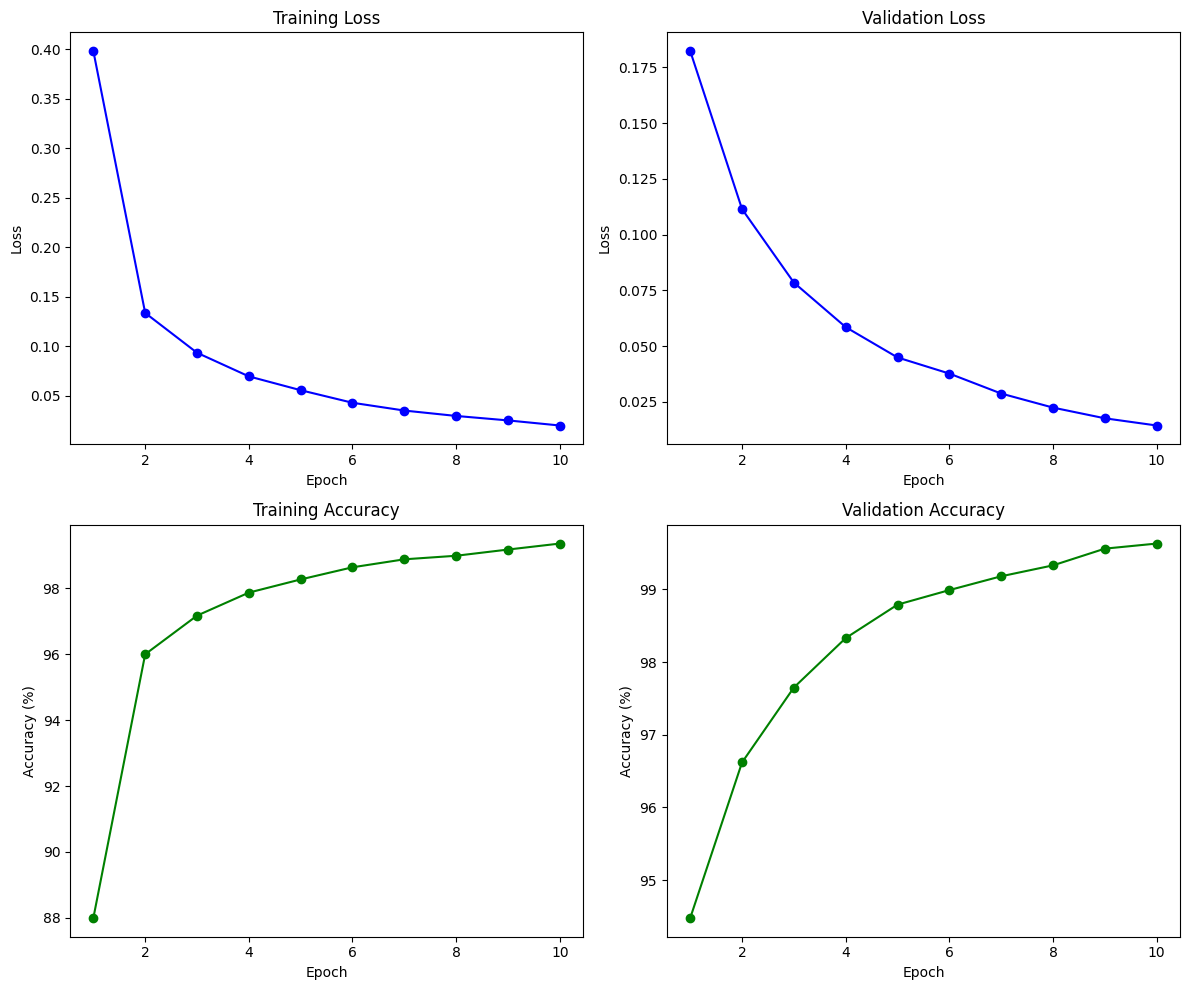

In [116]:
model_1 = FeedforwardNN()
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.1)

train(model_1, train_loader, val_loader, loss_fn_1, optimizer_1, 10)

Test Accuracy: 97.98%


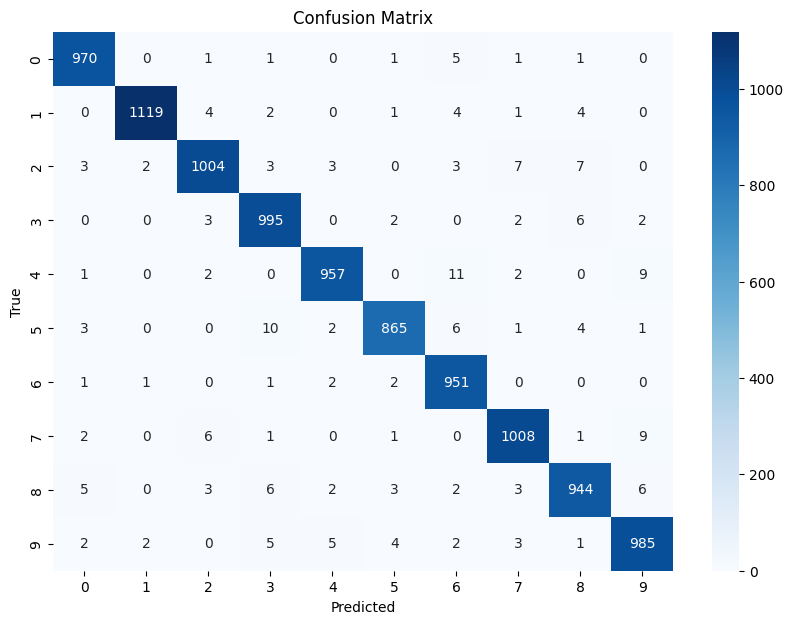

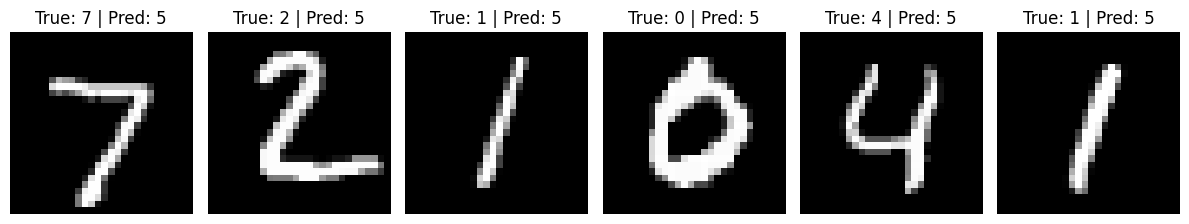

In [117]:
test(model_1, test_loader)

At learning rate = 0.05

Epoch [1/10]
Training Loss: 0.5470, Accuracy: 84.30%
Validation Loss: 0.2501, Accuracy: 92.75%
Epoch [2/10]
Training Loss: 0.1965, Accuracy: 94.12%
Validation Loss: 0.1639, Accuracy: 95.26%
Epoch [3/10]
Training Loss: 0.1360, Accuracy: 96.02%
Validation Loss: 0.1212, Accuracy: 96.48%
Epoch [4/10]
Training Loss: 0.1038, Accuracy: 96.89%
Validation Loss: 0.0959, Accuracy: 97.14%
Epoch [5/10]
Training Loss: 0.0836, Accuracy: 97.49%
Validation Loss: 0.0777, Accuracy: 97.74%
Epoch [6/10]
Training Loss: 0.0695, Accuracy: 97.83%
Validation Loss: 0.0619, Accuracy: 98.28%
Epoch [7/10]
Training Loss: 0.0584, Accuracy: 98.25%
Validation Loss: 0.0523, Accuracy: 98.53%
Epoch [8/10]
Training Loss: 0.0495, Accuracy: 98.49%
Validation Loss: 0.0429, Accuracy: 98.81%
Epoch [9/10]
Training Loss: 0.0424, Accuracy: 98.71%
Validation Loss: 0.0372, Accuracy: 99.08%
Epoch [10/10]
Training Loss: 0.0372, Accuracy: 98.84%
Validation Loss: 0.0314, Accuracy: 99.26%


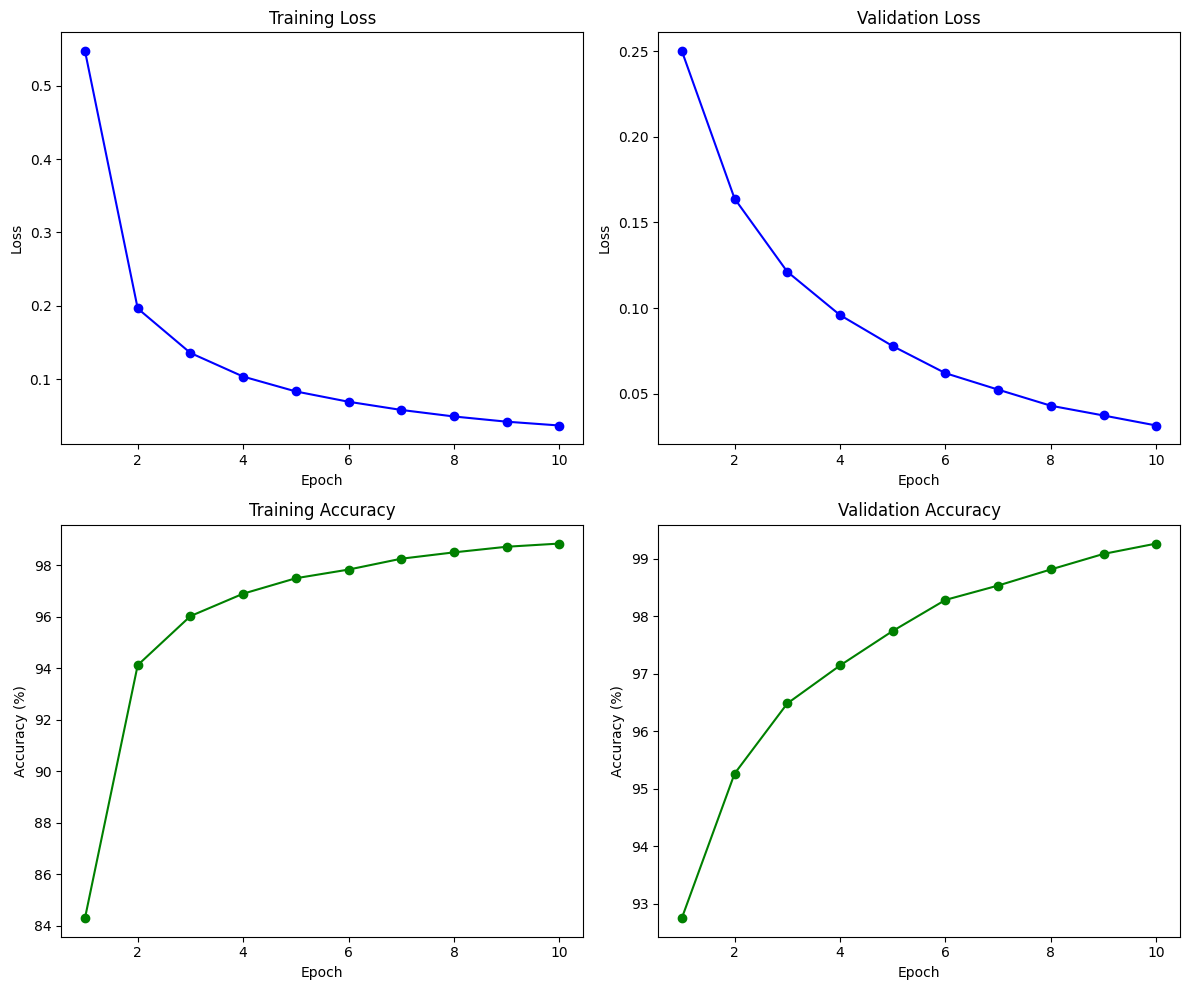

In [118]:
model_2 = FeedforwardNN()
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.05)

train(model_2, train_loader, val_loader, loss_fn_2, optimizer_2, 10)

Test Accuracy: 97.86%


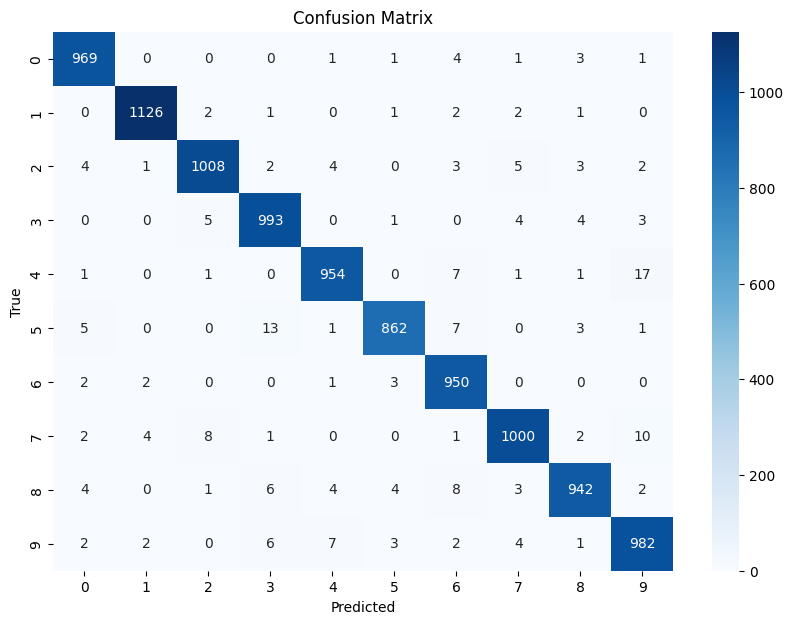

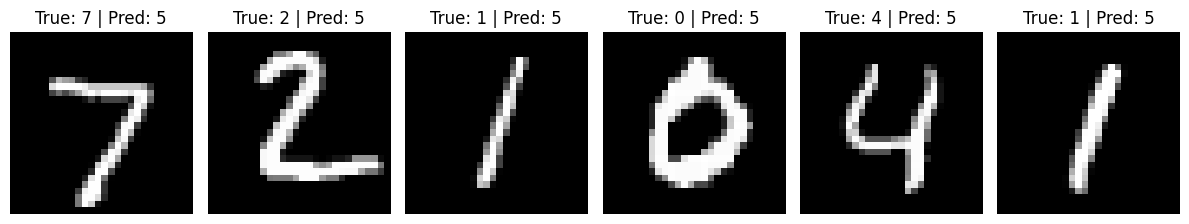

In [119]:
test(model_2, test_loader)

At learning rate = 0.01

Epoch [1/10]
Training Loss: 1.2652, Accuracy: 67.18%
Validation Loss: 0.4662, Accuracy: 87.11%
Epoch [2/10]
Training Loss: 0.3801, Accuracy: 89.36%
Validation Loss: 0.3373, Accuracy: 90.33%
Epoch [3/10]
Training Loss: 0.3119, Accuracy: 91.07%
Validation Loss: 0.2924, Accuracy: 91.52%
Epoch [4/10]
Training Loss: 0.2732, Accuracy: 92.23%
Validation Loss: 0.2593, Accuracy: 92.57%
Epoch [5/10]
Training Loss: 0.2432, Accuracy: 93.08%
Validation Loss: 0.2327, Accuracy: 93.37%
Epoch [6/10]
Training Loss: 0.2175, Accuracy: 93.70%
Validation Loss: 0.2107, Accuracy: 94.01%
Epoch [7/10]
Training Loss: 0.1958, Accuracy: 94.37%
Validation Loss: 0.1910, Accuracy: 94.51%
Epoch [8/10]
Training Loss: 0.1773, Accuracy: 94.93%
Validation Loss: 0.1743, Accuracy: 95.07%
Epoch [9/10]
Training Loss: 0.1615, Accuracy: 95.28%
Validation Loss: 0.1598, Accuracy: 95.54%
Epoch [10/10]
Training Loss: 0.1482, Accuracy: 95.67%
Validation Loss: 0.1466, Accuracy: 96.05%


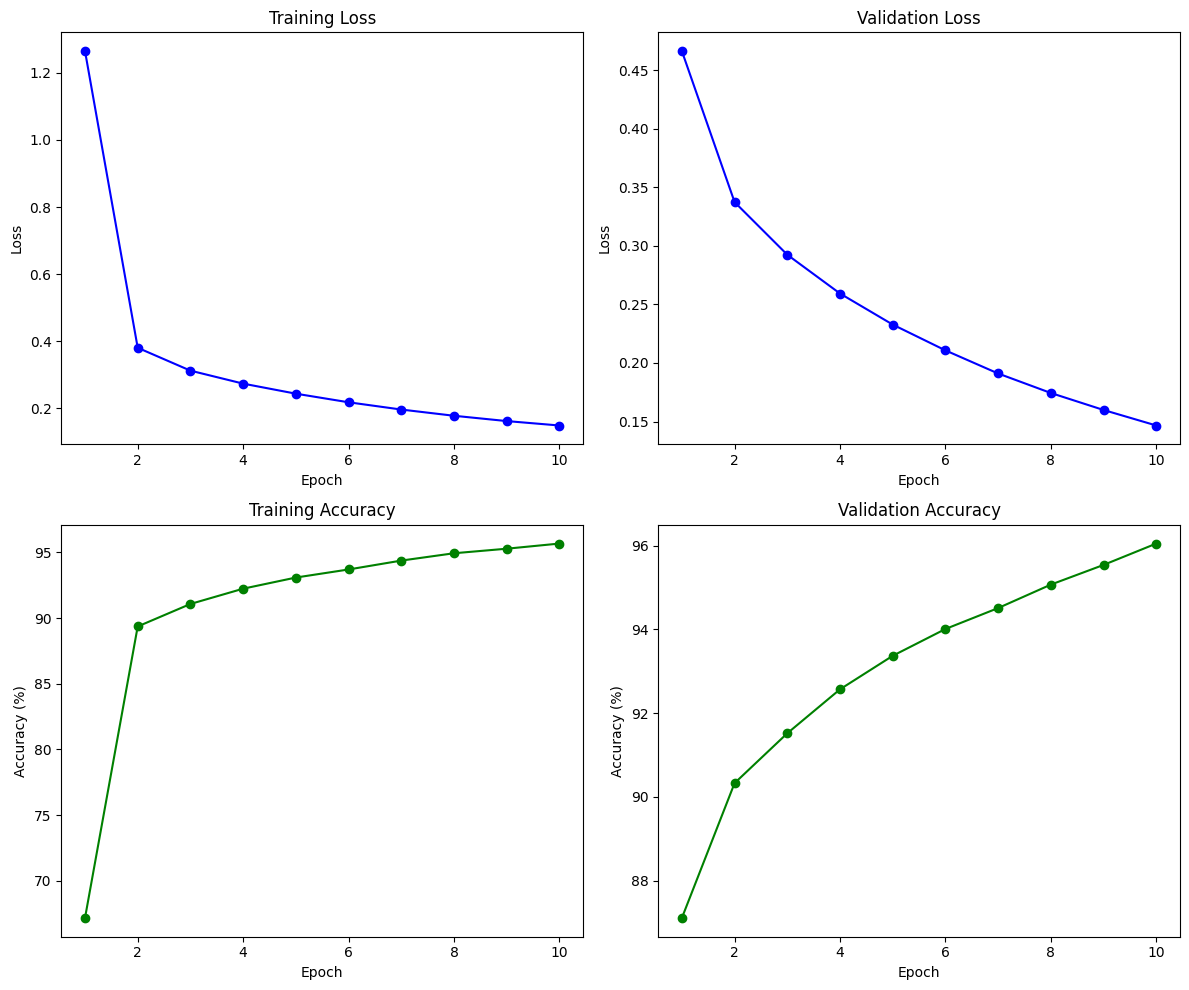

In [120]:
model_3 = FeedforwardNN()
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01)

train(model_3, train_loader, val_loader, loss_fn_3, optimizer_3, 10)

Test Accuracy: 95.57%


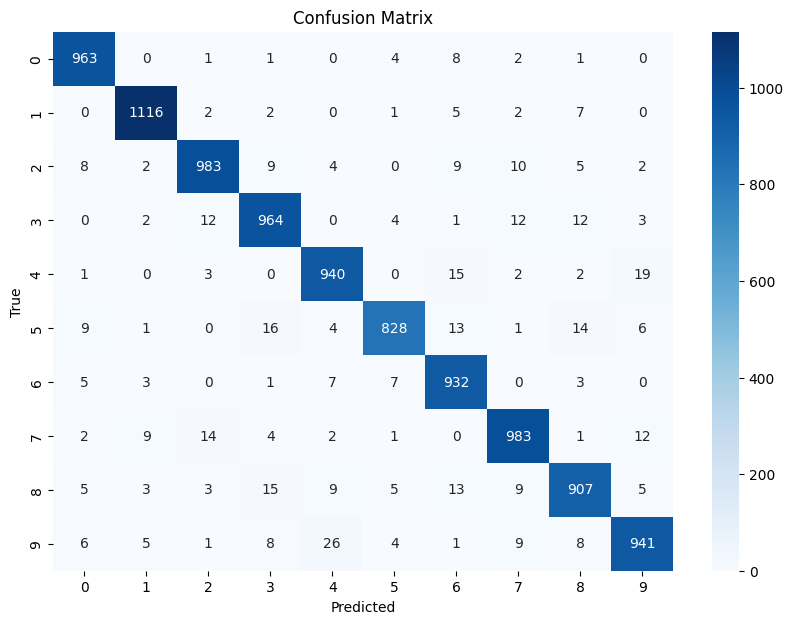

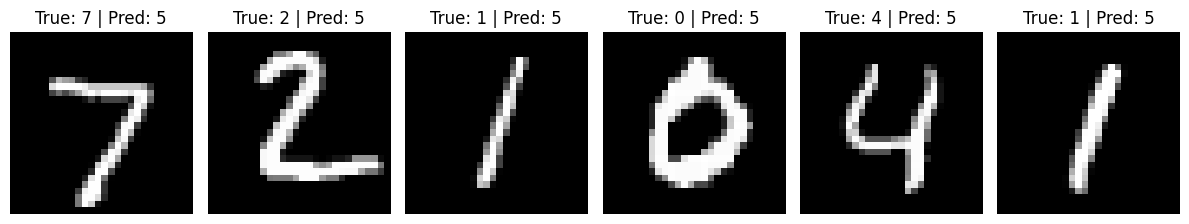

In [121]:
test(model_3, test_loader)

At learning rate = 0.001

Epoch [1/10]
Training Loss: 2.2841, Accuracy: 15.36%
Validation Loss: 2.2509, Accuracy: 30.70%
Epoch [2/10]
Training Loss: 2.1888, Accuracy: 46.08%
Validation Loss: 2.0987, Accuracy: 53.70%
Epoch [3/10]
Training Loss: 1.9488, Accuracy: 59.77%
Validation Loss: 1.7513, Accuracy: 66.20%
Epoch [4/10]
Training Loss: 1.4814, Accuracy: 70.15%
Validation Loss: 1.2071, Accuracy: 74.52%
Epoch [5/10]
Training Loss: 0.9907, Accuracy: 77.51%
Validation Loss: 0.8388, Accuracy: 80.46%
Epoch [6/10]
Training Loss: 0.7369, Accuracy: 81.86%
Validation Loss: 0.6672, Accuracy: 83.21%
Epoch [7/10]
Training Loss: 0.6107, Accuracy: 84.30%
Validation Loss: 0.5729, Accuracy: 84.98%
Epoch [8/10]
Training Loss: 0.5367, Accuracy: 85.68%
Validation Loss: 0.5135, Accuracy: 86.20%
Epoch [9/10]
Training Loss: 0.4881, Accuracy: 86.74%
Validation Loss: 0.4733, Accuracy: 87.16%
Epoch [10/10]
Training Loss: 0.4540, Accuracy: 87.51%
Validation Loss: 0.4436, Accuracy: 87.81%


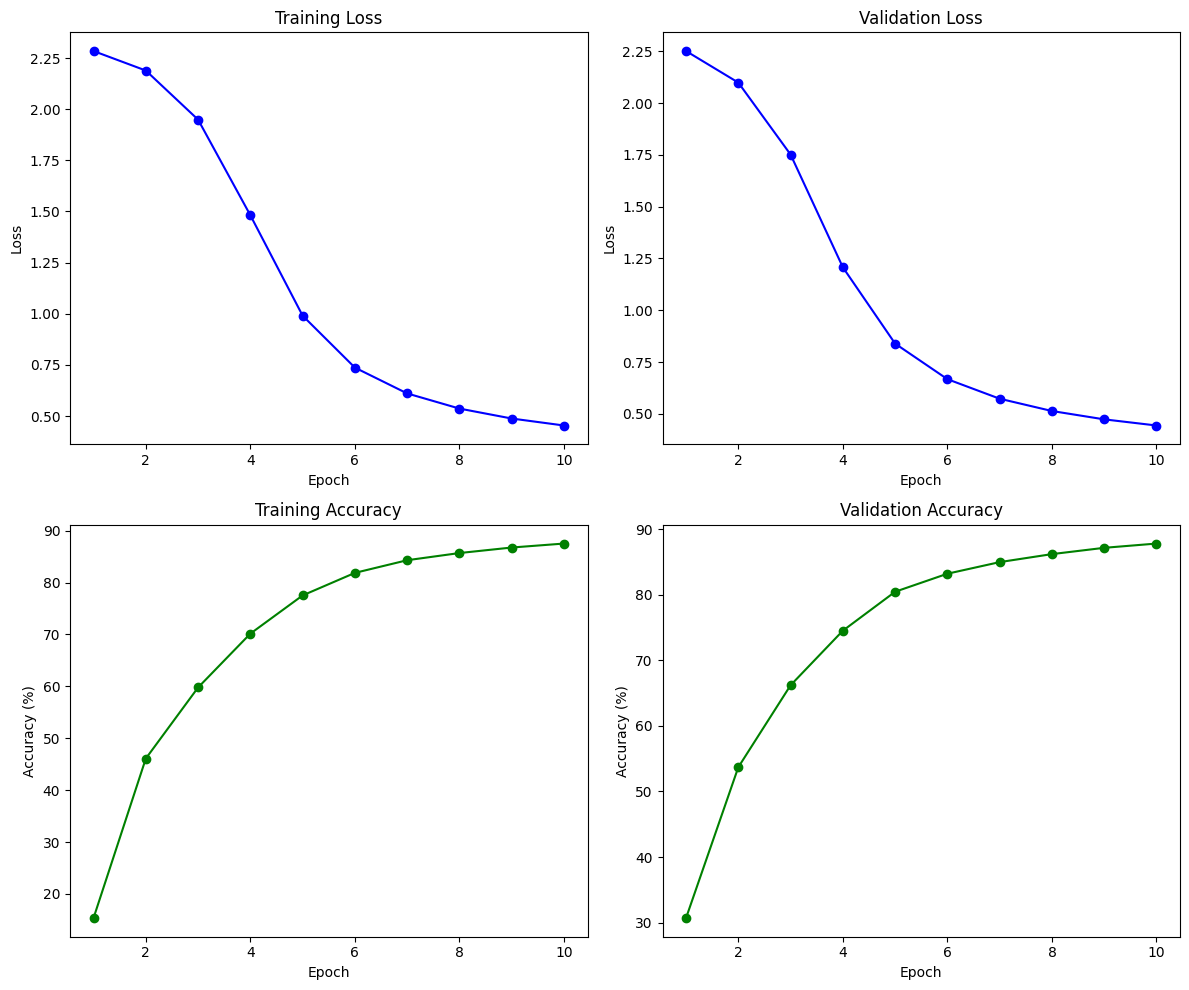

In [122]:
model_4 = FeedforwardNN()
loss_fn_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.001)

train(model_4, train_loader, val_loader, loss_fn_4, optimizer_4, 10)


Test Accuracy: 88.44%


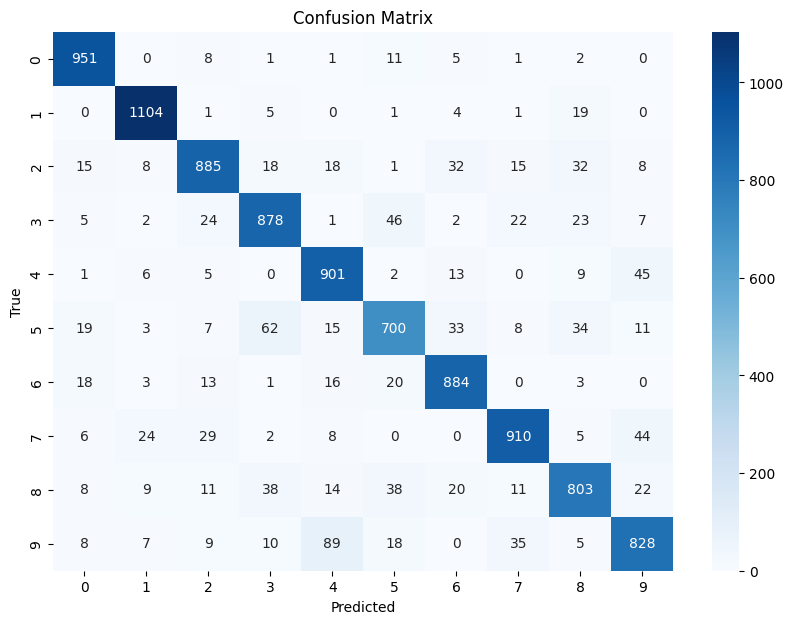

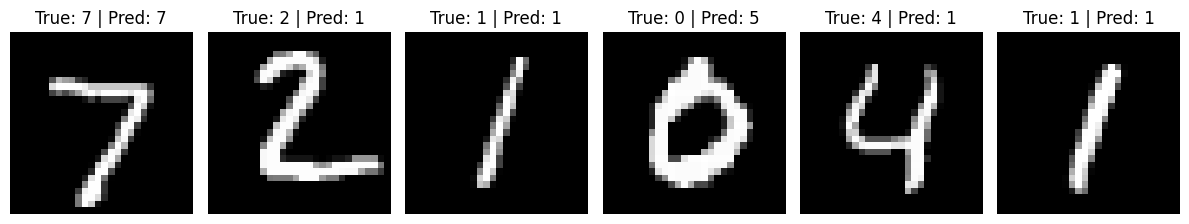

In [123]:
test(model_4, test_loader)

At learning rate = 0.0001

Epoch [1/10]
Training Loss: 1.2786, Accuracy: 64.90%
Validation Loss: 0.4851, Accuracy: 86.65%
Epoch [2/10]
Training Loss: 0.3894, Accuracy: 89.09%
Validation Loss: 0.3454, Accuracy: 90.24%
Epoch [3/10]
Training Loss: 0.3173, Accuracy: 90.98%
Validation Loss: 0.2978, Accuracy: 91.66%
Epoch [4/10]
Training Loss: 0.2776, Accuracy: 92.01%
Validation Loss: 0.2631, Accuracy: 92.58%
Epoch [5/10]
Training Loss: 0.2459, Accuracy: 92.95%
Validation Loss: 0.2355, Accuracy: 93.31%
Epoch [6/10]
Training Loss: 0.2200, Accuracy: 93.67%
Validation Loss: 0.2120, Accuracy: 93.94%
Epoch [7/10]
Training Loss: 0.1983, Accuracy: 94.27%
Validation Loss: 0.1927, Accuracy: 94.48%
Epoch [8/10]
Training Loss: 0.1798, Accuracy: 94.86%
Validation Loss: 0.1753, Accuracy: 94.98%
Epoch [9/10]
Training Loss: 0.1643, Accuracy: 95.27%
Validation Loss: 0.1607, Accuracy: 95.43%
Epoch [10/10]
Training Loss: 0.1504, Accuracy: 95.62%
Validation Loss: 0.1483, Accuracy: 95.69%


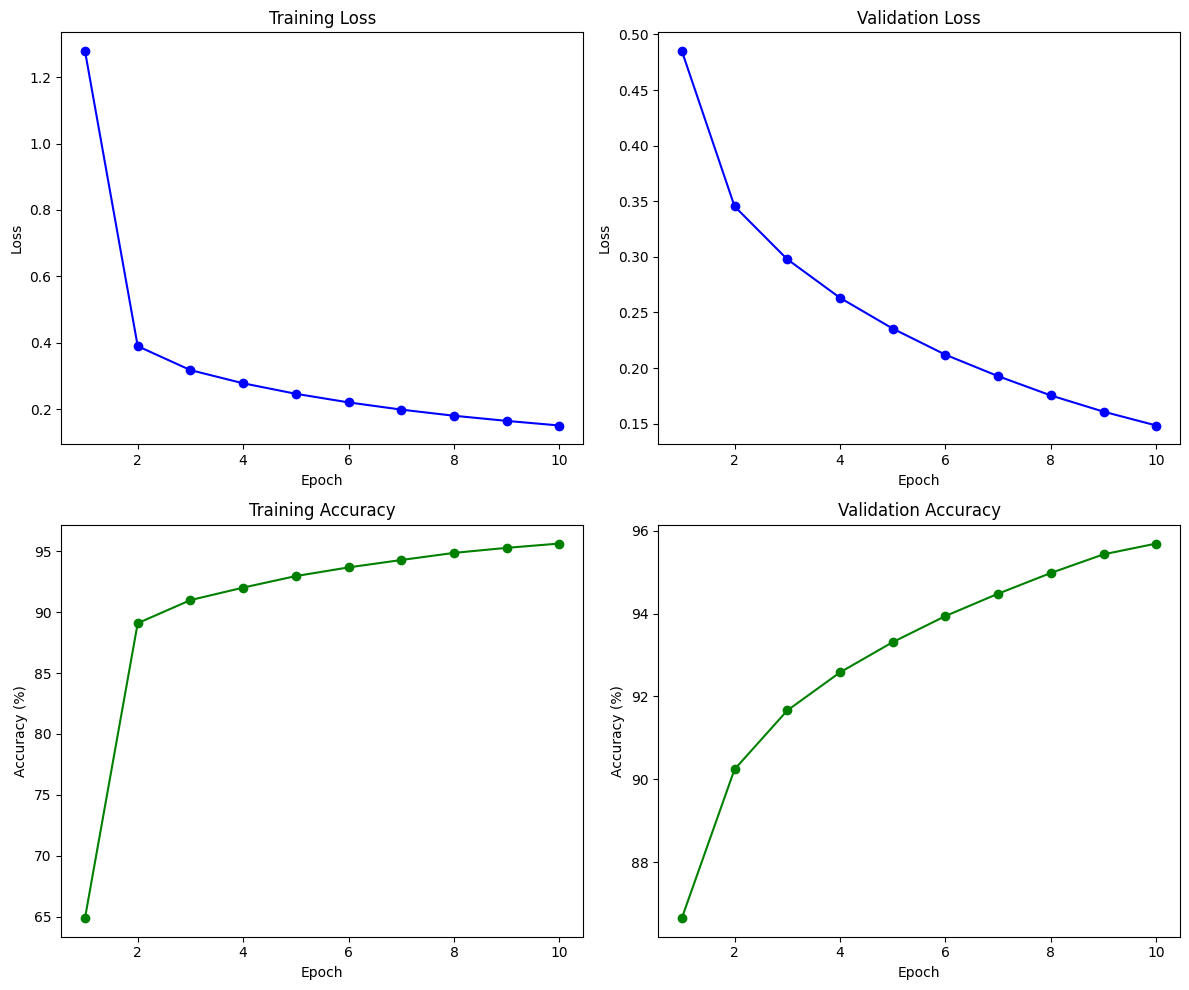

In [124]:
model_5 = FeedforwardNN()
loss_fn_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.SGD(model_5.parameters(), lr=0.01)

train(model_5, train_loader, val_loader, loss_fn_5, optimizer_5, 10)

Test Accuracy: 95.76%


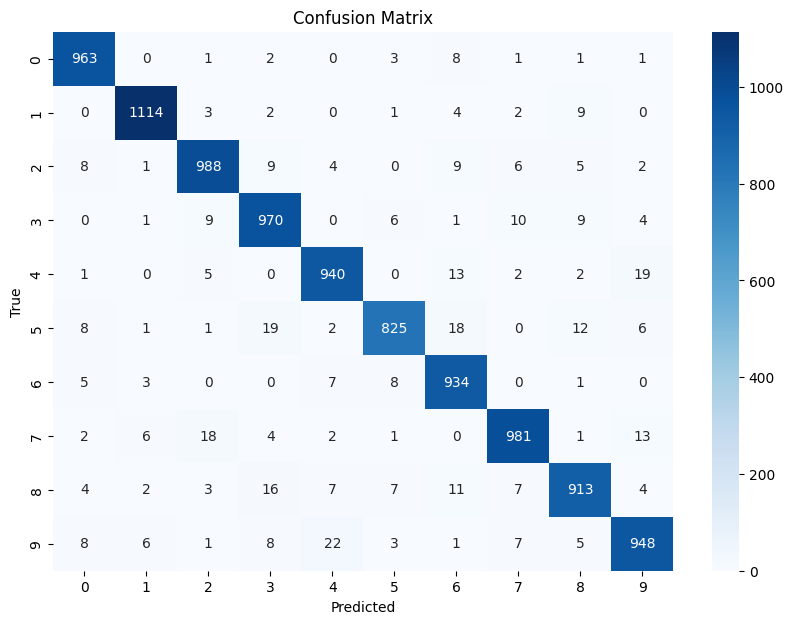

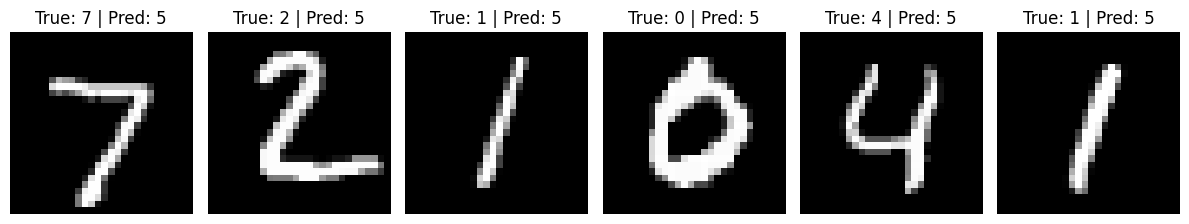

In [125]:
test(model_5, test_loader)

* At learning rate = **0.1** --- Accuracy = **97.98%**
* At learning rate = **0.05** --- Accuracy = **97.86%**
* At learning rate = **0.01** --- Accuracy = **95.57%**
* At learning rate = **0.001** --- Accuracy = **88.44%**
* At learning rate = **0.0001** --- Accuracy = **95.76%**

Then we choose leaning rate = **0.1** which is model_1 as it gives the highest accuracy

# Change Batch size [32, 64, 128, 256, 512]
* Learning rate = 0.1
* Neurons number: 128 then 64

At batch size = 32

Epoch [1/10]
Training Loss: 0.4057, Accuracy: 88.17%
Validation Loss: 0.1805, Accuracy: 94.62%
Epoch [2/10]
Training Loss: 0.1320, Accuracy: 96.07%
Validation Loss: 0.1131, Accuracy: 96.63%
Epoch [3/10]
Training Loss: 0.0911, Accuracy: 97.27%
Validation Loss: 0.0801, Accuracy: 97.56%
Epoch [4/10]
Training Loss: 0.0697, Accuracy: 97.83%
Validation Loss: 0.0604, Accuracy: 98.31%
Epoch [5/10]
Training Loss: 0.0557, Accuracy: 98.20%
Validation Loss: 0.0478, Accuracy: 98.55%
Epoch [6/10]
Training Loss: 0.0457, Accuracy: 98.56%
Validation Loss: 0.0367, Accuracy: 99.06%
Epoch [7/10]
Training Loss: 0.0366, Accuracy: 98.84%
Validation Loss: 0.0301, Accuracy: 99.21%
Epoch [8/10]
Training Loss: 0.0303, Accuracy: 99.05%
Validation Loss: 0.0266, Accuracy: 99.24%
Epoch [9/10]
Training Loss: 0.0259, Accuracy: 99.15%
Validation Loss: 0.0222, Accuracy: 99.32%
Epoch [10/10]
Training Loss: 0.0216, Accuracy: 99.33%
Validation Loss: 0.0164, Accuracy: 99.54%


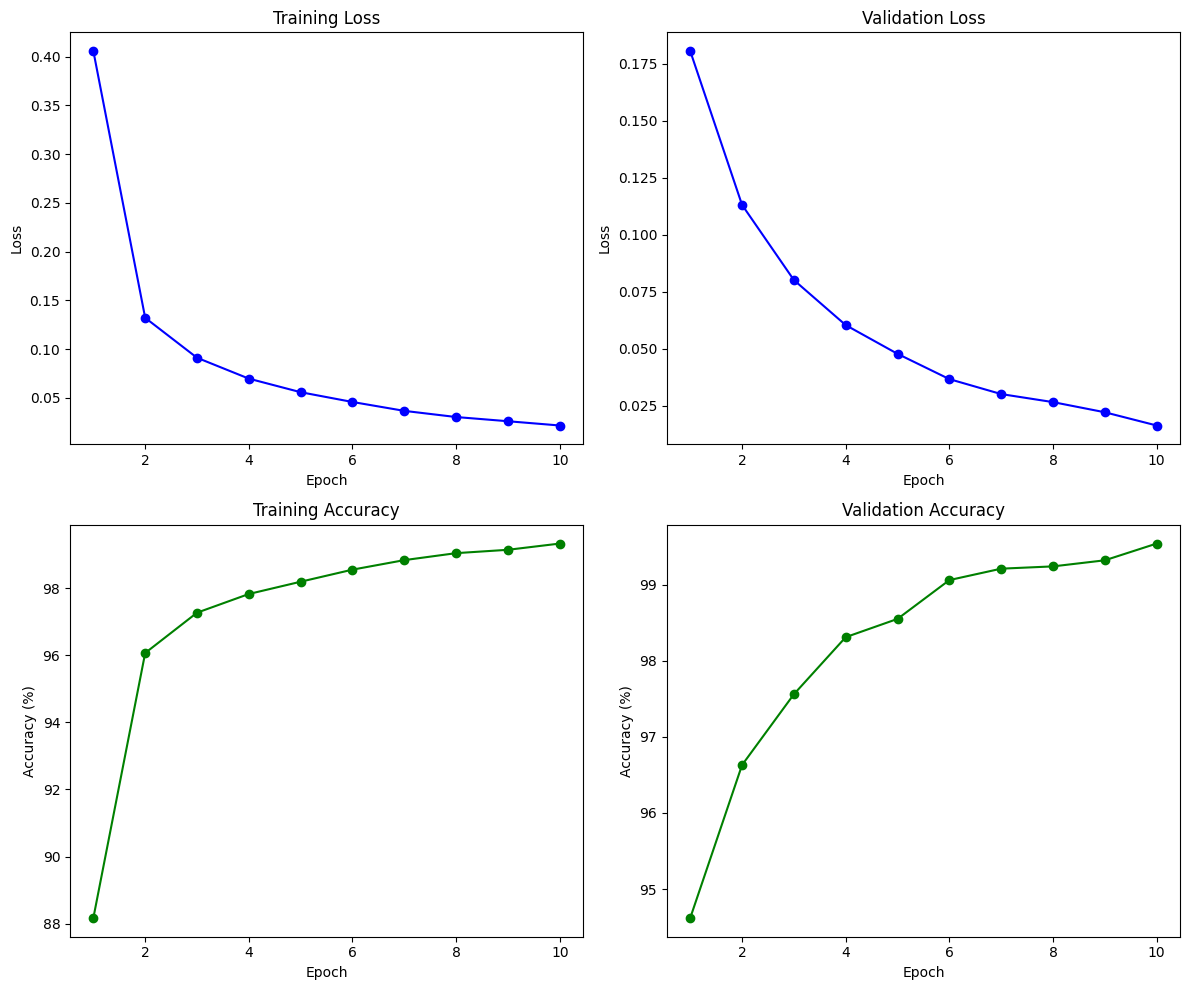

In [126]:
batch_size = 32

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_6 = FeedforwardNN()
loss_fn_6 = nn.CrossEntropyLoss()
optimizer_6 = optim.SGD(model_6.parameters(), lr=0.1)

train(model_6, train_loader, val_loader, loss_fn_6, optimizer_6, 10)

Test Accuracy: 98.06%


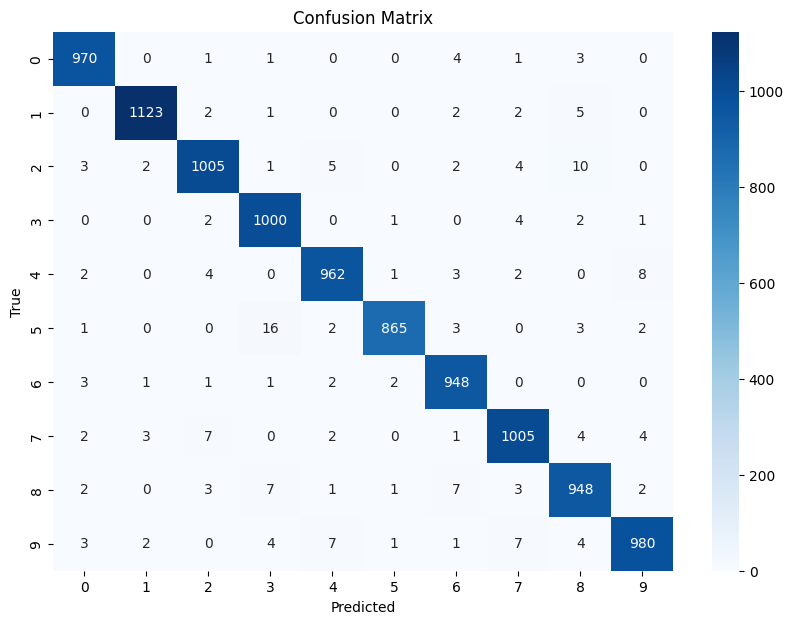

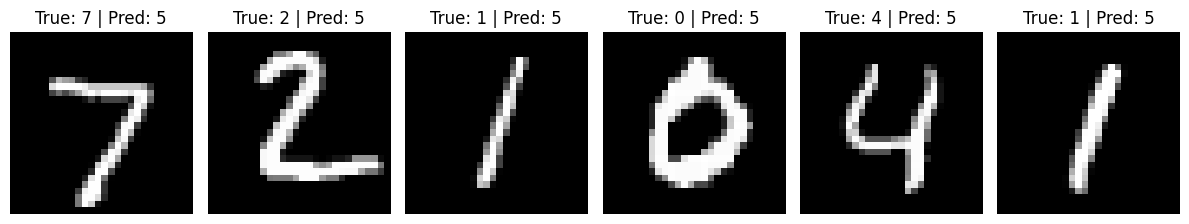

In [127]:
test(model_6, test_loader)

At batch size = 64

Epoch [1/10]
Training Loss: 0.5562, Accuracy: 83.75%
Validation Loss: 0.2534, Accuracy: 92.67%
Epoch [2/10]
Training Loss: 0.2003, Accuracy: 94.08%
Validation Loss: 0.1623, Accuracy: 94.94%
Epoch [3/10]
Training Loss: 0.1374, Accuracy: 95.88%
Validation Loss: 0.1196, Accuracy: 96.29%
Epoch [4/10]
Training Loss: 0.1051, Accuracy: 96.83%
Validation Loss: 0.0940, Accuracy: 97.11%
Epoch [5/10]
Training Loss: 0.0856, Accuracy: 97.38%
Validation Loss: 0.0756, Accuracy: 97.79%
Epoch [6/10]
Training Loss: 0.0709, Accuracy: 97.85%
Validation Loss: 0.0630, Accuracy: 98.09%
Epoch [7/10]
Training Loss: 0.0586, Accuracy: 98.26%
Validation Loss: 0.0531, Accuracy: 98.53%
Epoch [8/10]
Training Loss: 0.0510, Accuracy: 98.44%
Validation Loss: 0.0458, Accuracy: 98.66%
Epoch [9/10]
Training Loss: 0.0434, Accuracy: 98.65%
Validation Loss: 0.0389, Accuracy: 98.91%
Epoch [10/10]
Training Loss: 0.0380, Accuracy: 98.85%
Validation Loss: 0.0341, Accuracy: 99.08%


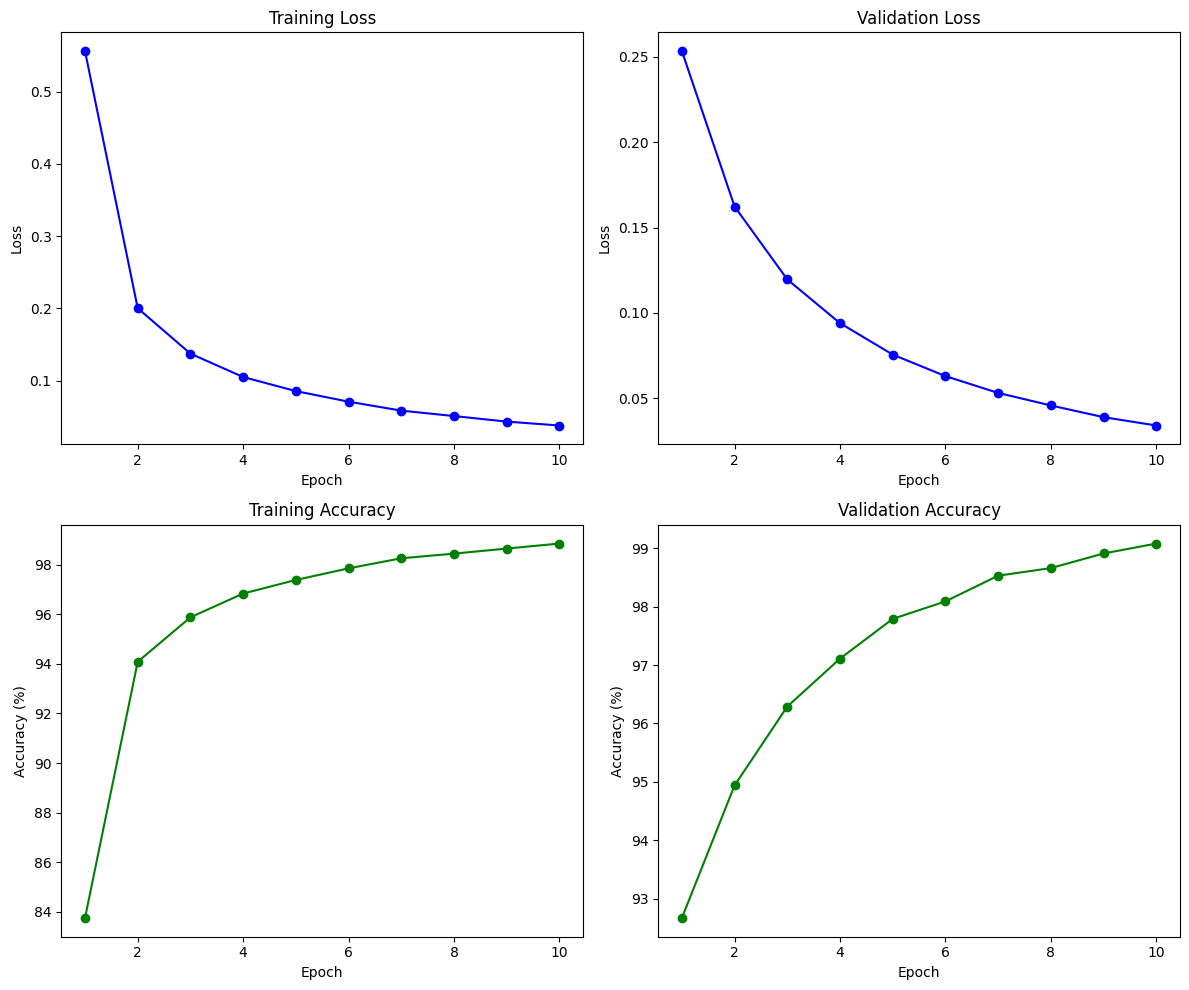

In [128]:
batch_size = 64

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_7 = FeedforwardNN()
loss_fn_7 = nn.CrossEntropyLoss()
optimizer_7 = optim.SGD(model_7.parameters(), lr=0.1)

train(model_7, train_loader, val_loader, loss_fn_7, optimizer_7, 10)

Test Accuracy: 97.70%


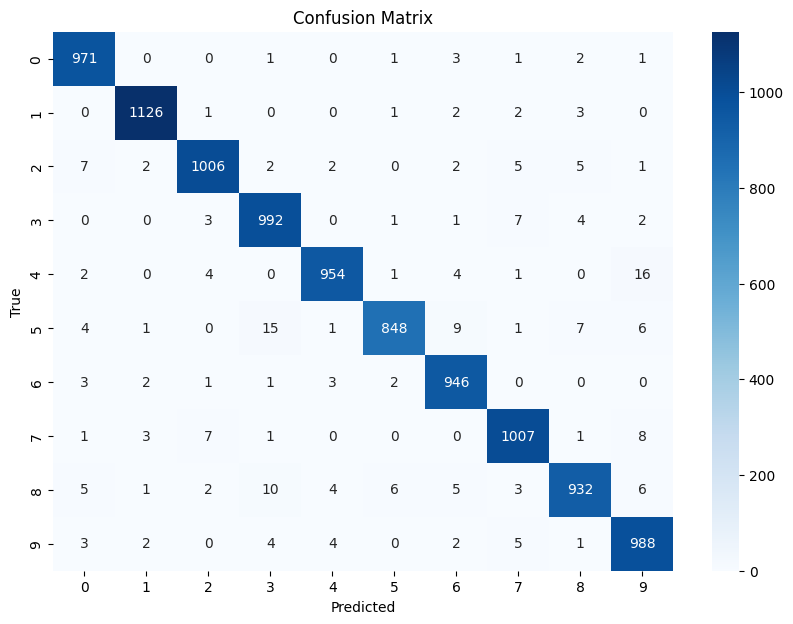

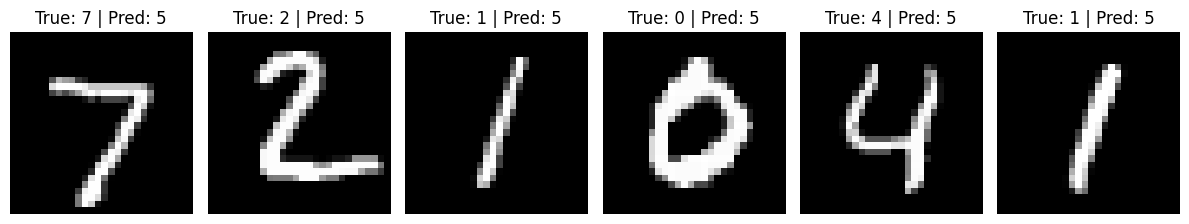

In [129]:
test(model_7, test_loader)

At batch size = 128

Epoch [1/10]
Training Loss: 0.7638, Accuracy: 77.84%
Validation Loss: 0.3287, Accuracy: 90.48%
Epoch [2/10]
Training Loss: 0.2791, Accuracy: 91.91%
Validation Loss: 0.2353, Accuracy: 93.09%
Epoch [3/10]
Training Loss: 0.2076, Accuracy: 94.07%
Validation Loss: 0.1824, Accuracy: 94.68%
Epoch [4/10]
Training Loss: 0.1627, Accuracy: 95.29%
Validation Loss: 0.1487, Accuracy: 95.53%
Epoch [5/10]
Training Loss: 0.1323, Accuracy: 96.17%
Validation Loss: 0.1252, Accuracy: 96.31%
Epoch [6/10]
Training Loss: 0.1118, Accuracy: 96.81%
Validation Loss: 0.1062, Accuracy: 96.86%
Epoch [7/10]
Training Loss: 0.0957, Accuracy: 97.21%
Validation Loss: 0.0927, Accuracy: 97.36%
Epoch [8/10]
Training Loss: 0.0835, Accuracy: 97.59%
Validation Loss: 0.0814, Accuracy: 97.64%
Epoch [9/10]
Training Loss: 0.0735, Accuracy: 97.88%
Validation Loss: 0.0725, Accuracy: 97.90%
Epoch [10/10]
Training Loss: 0.0658, Accuracy: 98.11%
Validation Loss: 0.0650, Accuracy: 98.16%


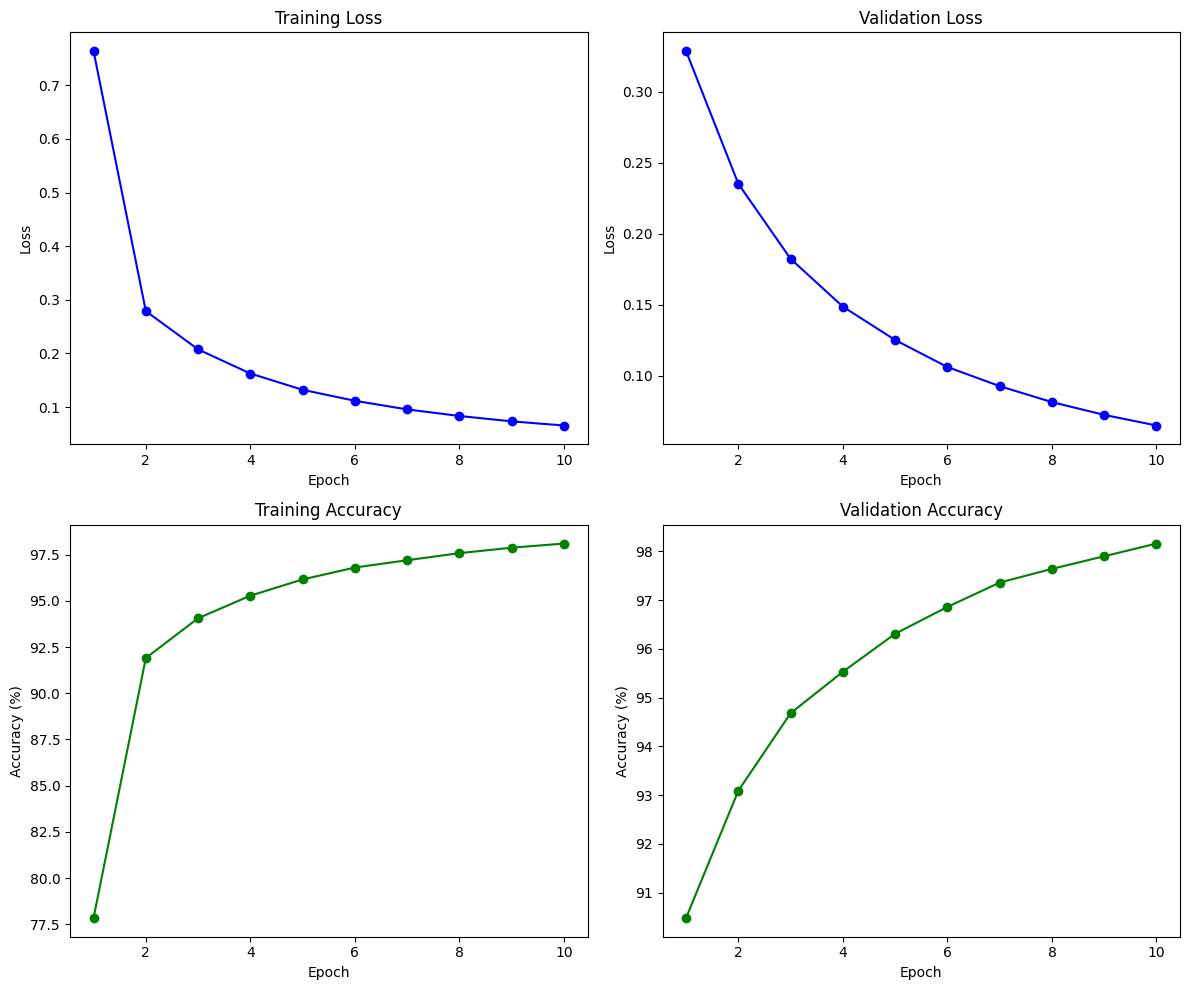

In [130]:
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_8 = FeedforwardNN()
loss_fn_8 = nn.CrossEntropyLoss()
optimizer_8 = optim.SGD(model_8.parameters(), lr=0.1)

train(model_8, train_loader, val_loader, loss_fn_8, optimizer_8, 10)

Test Accuracy: 97.36%


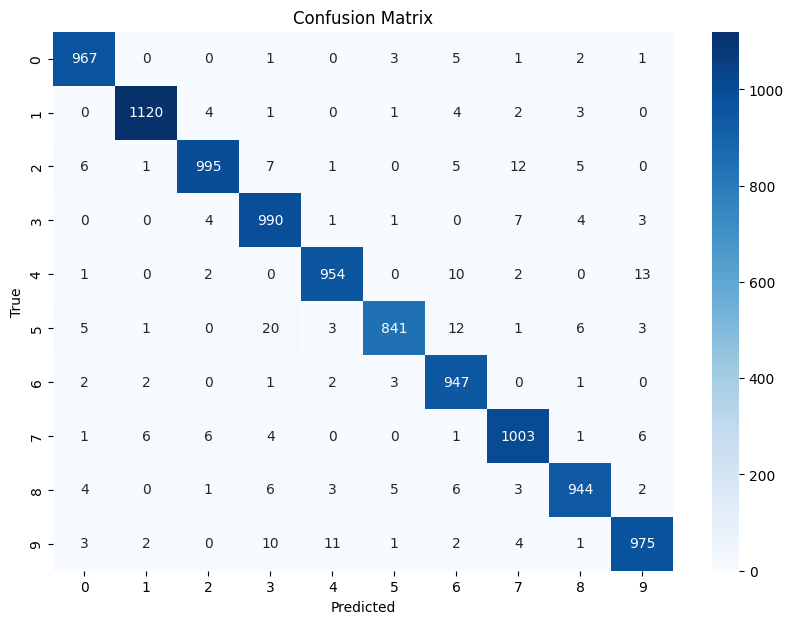

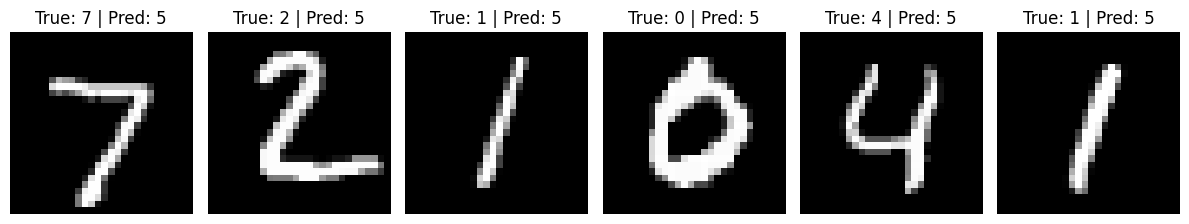

In [131]:
test(model_8, test_loader)

At batch size = 256

Epoch [1/10]
Training Loss: 1.1484, Accuracy: 69.18%
Validation Loss: 0.4331, Accuracy: 87.55%
Epoch [2/10]
Training Loss: 0.3640, Accuracy: 89.39%
Validation Loss: 0.3126, Accuracy: 91.02%
Epoch [3/10]
Training Loss: 0.2923, Accuracy: 91.62%
Validation Loss: 0.2637, Accuracy: 92.14%
Epoch [4/10]
Training Loss: 0.2473, Accuracy: 92.83%
Validation Loss: 0.2260, Accuracy: 93.27%
Epoch [5/10]
Training Loss: 0.2131, Accuracy: 93.83%
Validation Loss: 0.1981, Accuracy: 94.09%
Epoch [6/10]
Training Loss: 0.1868, Accuracy: 94.58%
Validation Loss: 0.1755, Accuracy: 94.84%
Epoch [7/10]
Training Loss: 0.1652, Accuracy: 95.23%
Validation Loss: 0.1581, Accuracy: 95.40%
Epoch [8/10]
Training Loss: 0.1478, Accuracy: 95.68%
Validation Loss: 0.1427, Accuracy: 95.82%
Epoch [9/10]
Training Loss: 0.1339, Accuracy: 96.07%
Validation Loss: 0.1312, Accuracy: 96.26%
Epoch [10/10]
Training Loss: 0.1224, Accuracy: 96.45%
Validation Loss: 0.1206, Accuracy: 96.47%


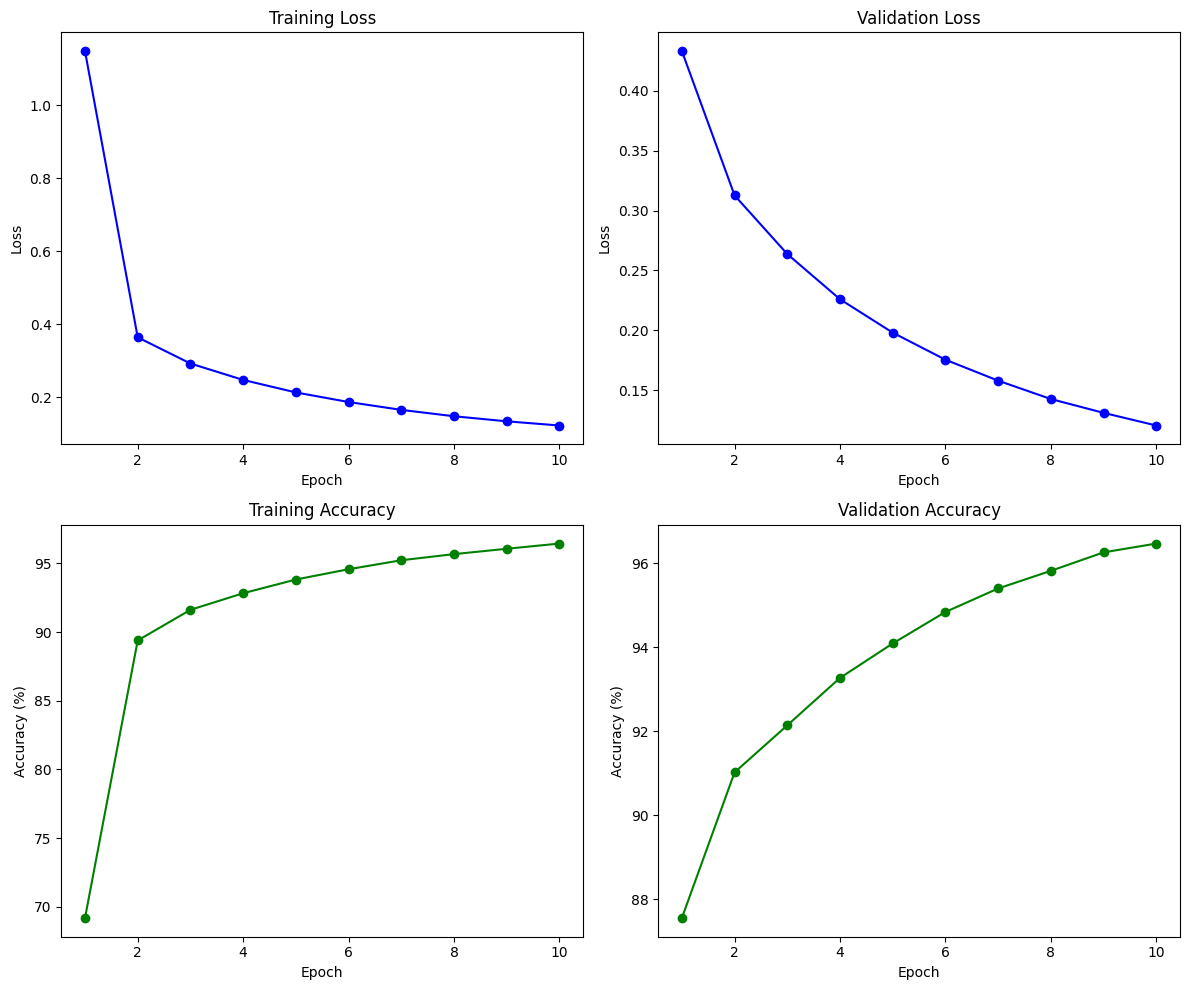

In [132]:
batch_size = 256

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_9 = FeedforwardNN()
loss_fn_9 = nn.CrossEntropyLoss()
optimizer_9 = optim.SGD(model_9.parameters(), lr=0.1)

train(model_9, train_loader, val_loader, loss_fn_9, optimizer_9, 10)

Test Accuracy: 96.34%


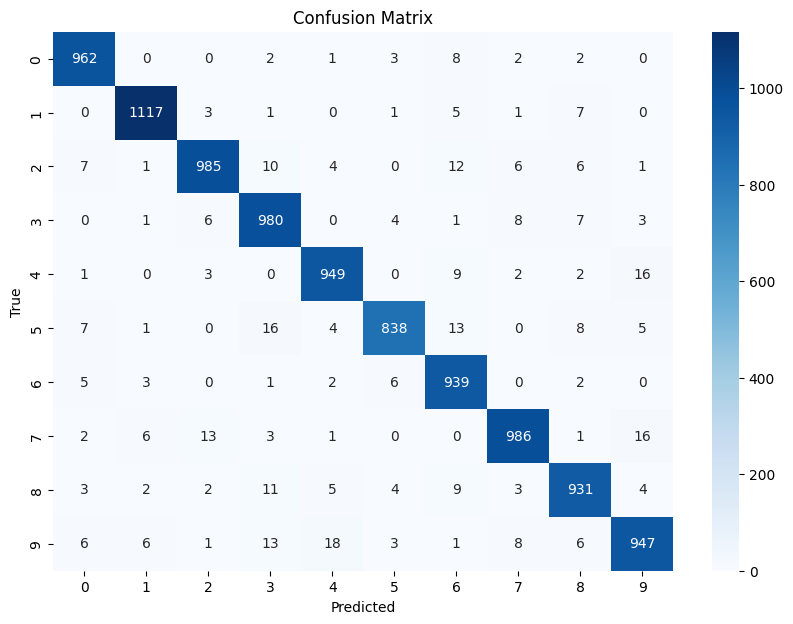

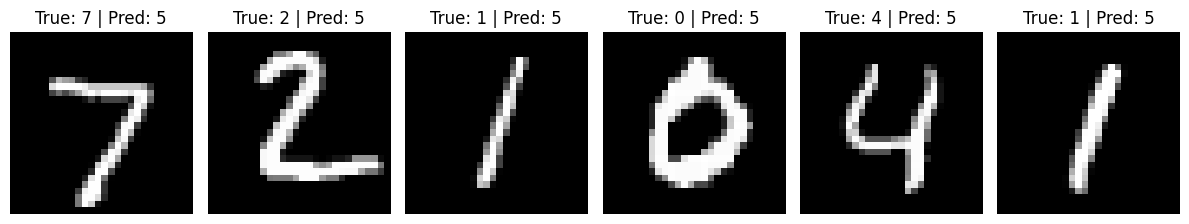

In [133]:
test(model_9, test_loader)

At batch size = 512

Epoch [1/10]
Training Loss: 1.7644, Accuracy: 50.31%
Validation Loss: 0.7763, Accuracy: 78.84%
Epoch [2/10]
Training Loss: 0.5342, Accuracy: 84.85%
Validation Loss: 0.4256, Accuracy: 87.95%
Epoch [3/10]
Training Loss: 0.3805, Accuracy: 89.20%
Validation Loss: 0.3492, Accuracy: 90.11%
Epoch [4/10]
Training Loss: 0.3292, Accuracy: 90.53%
Validation Loss: 0.3115, Accuracy: 91.20%
Epoch [5/10]
Training Loss: 0.2985, Accuracy: 91.34%
Validation Loss: 0.2863, Accuracy: 91.94%
Epoch [6/10]
Training Loss: 0.2750, Accuracy: 92.17%
Validation Loss: 0.2645, Accuracy: 92.47%
Epoch [7/10]
Training Loss: 0.2546, Accuracy: 92.68%
Validation Loss: 0.2454, Accuracy: 93.09%
Epoch [8/10]
Training Loss: 0.2355, Accuracy: 93.28%
Validation Loss: 0.2269, Accuracy: 93.62%
Epoch [9/10]
Training Loss: 0.2181, Accuracy: 93.73%
Validation Loss: 0.2113, Accuracy: 94.04%
Epoch [10/10]
Training Loss: 0.2036, Accuracy: 94.30%
Validation Loss: 0.1977, Accuracy: 94.33%


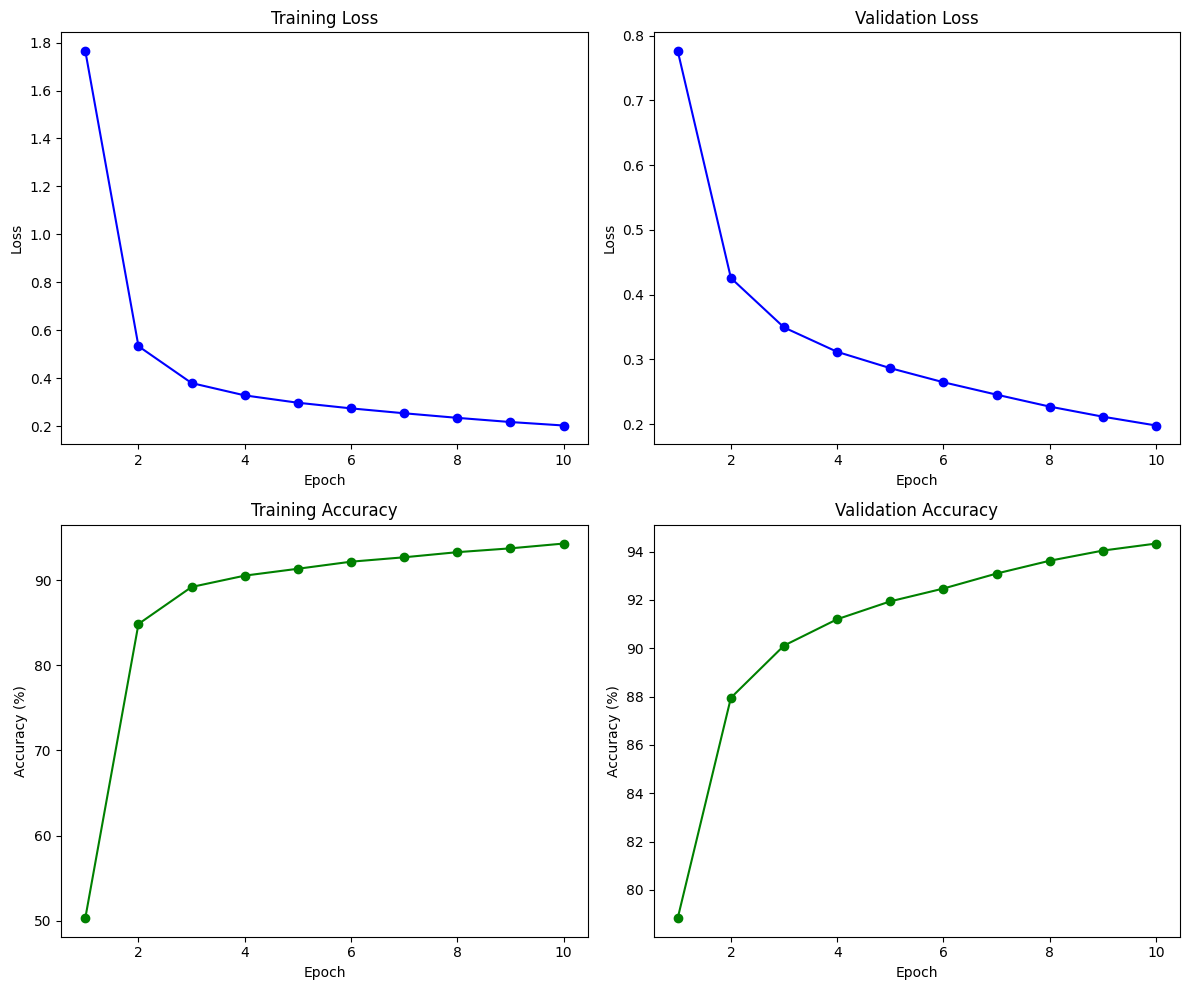

In [134]:
batch_size = 512

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_10 = FeedforwardNN()
loss_fn_10 = nn.CrossEntropyLoss()
optimizer_10 = optim.SGD(model_10.parameters(), lr=0.1)

train(model_10, train_loader, val_loader, loss_fn_10, optimizer_10, 10)

Test Accuracy: 94.45%


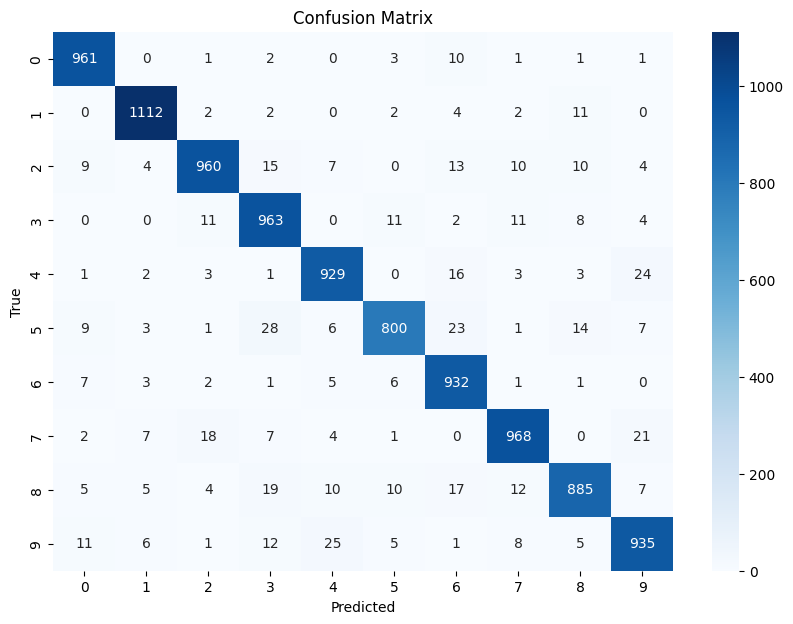

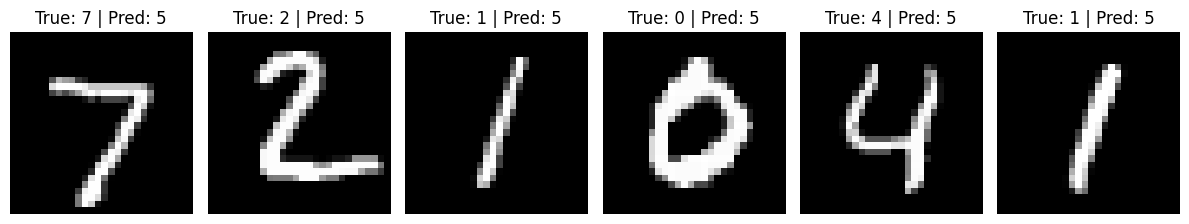

In [135]:
test(model_10, test_loader)

* At batch size = **32** --- Accuracy = **98.06%**
* At batch size = **64** --- Accuracy = **97.70%**
* At batch size = **128** --- Accuracy = **97.36%**
* At batch size = **256** --- Accuracy = **96.34%**
* At batch size = **512** --- Accuracy = **94.45%**

Then we choose batch size = **32** which is model_6 as it gives the highest accuracy

# Change number of neurons and layers  
* Learning rate = 0.1
* Batch size = 32

In [136]:
batch_size = 32

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Two Layers with 128 and 64 Neurons

Epoch [1/10]
Training Loss: 0.4084, Accuracy: 88.00%
Validation Loss: 0.1849, Accuracy: 94.41%
Epoch [2/10]
Training Loss: 0.1374, Accuracy: 95.93%
Validation Loss: 0.1129, Accuracy: 96.64%
Epoch [3/10]
Training Loss: 0.0914, Accuracy: 97.26%
Validation Loss: 0.0761, Accuracy: 97.76%
Epoch [4/10]
Training Loss: 0.0704, Accuracy: 97.83%
Validation Loss: 0.0568, Accuracy: 98.41%
Epoch [5/10]
Training Loss: 0.0560, Accuracy: 98.24%
Validation Loss: 0.0469, Accuracy: 98.60%
Epoch [6/10]
Training Loss: 0.0448, Accuracy: 98.51%
Validation Loss: 0.0347, Accuracy: 98.97%
Epoch [7/10]
Training Loss: 0.0376, Accuracy: 98.82%
Validation Loss: 0.0277, Accuracy: 99.20%
Epoch [8/10]
Training Loss: 0.0291, Accuracy: 99.11%
Validation Loss: 0.0235, Accuracy: 99.34%
Epoch [9/10]
Training Loss: 0.0249, Accuracy: 99.24%
Validation Loss: 0.0173, Accuracy: 99.50%
Epoch [10/10]
Training Loss: 0.0197, Accuracy: 99.34%
Validation Loss: 0.0134, Accuracy: 99.65%


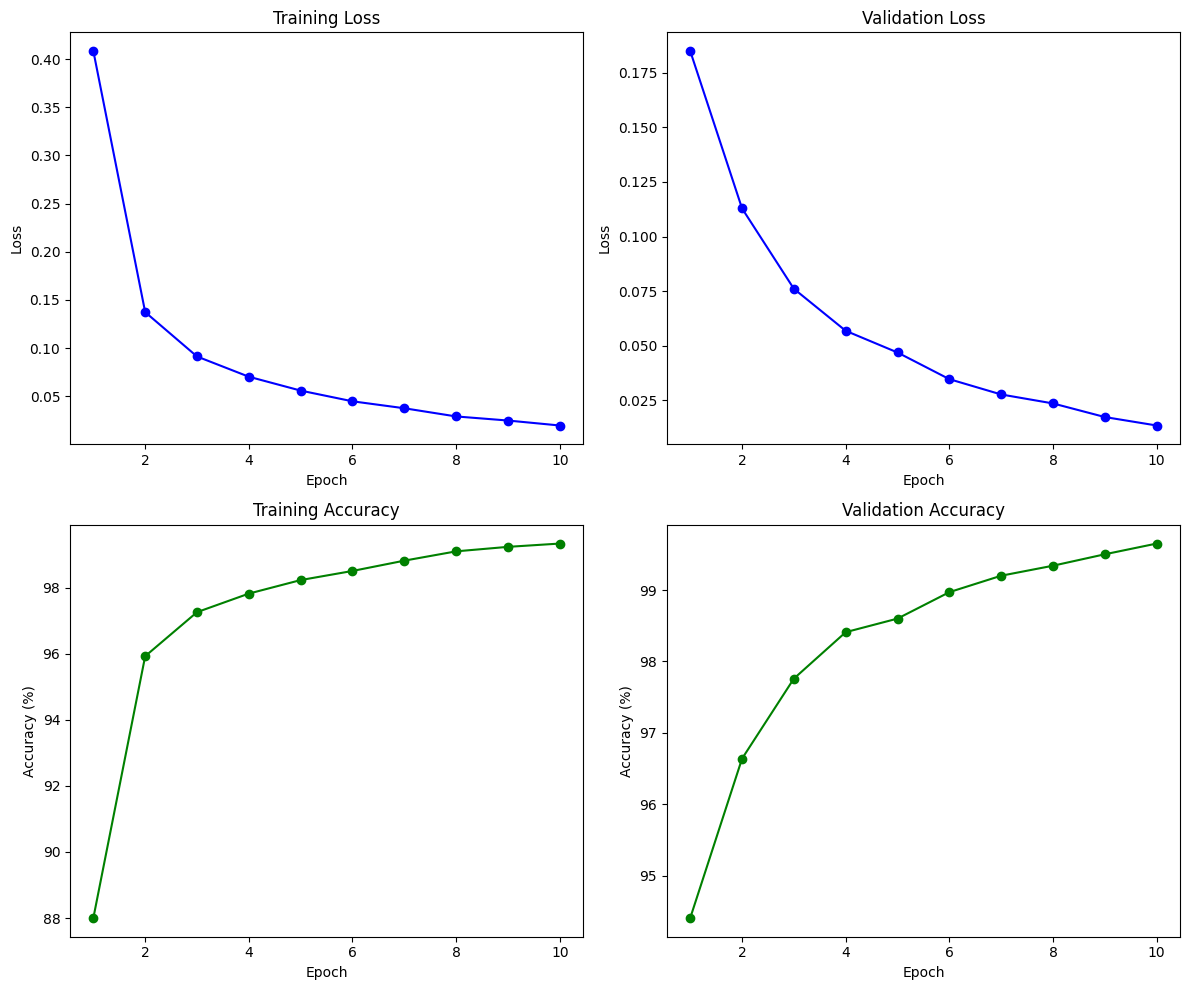

In [137]:
class FeedforwardNN_1(nn.Module):
    def __init__(self):
        super(FeedforwardNN_1, self).__init__()

        # Two layers with 128 and 64 neurons
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_11 = FeedforwardNN_1()
loss_fn_11 = nn.CrossEntropyLoss()
optimizer_11 = optim.SGD(model_11.parameters(), lr=0.1)

train(model_11, train_loader, val_loader, loss_fn_11, optimizer_11, 10)

Test Accuracy: 98.01%


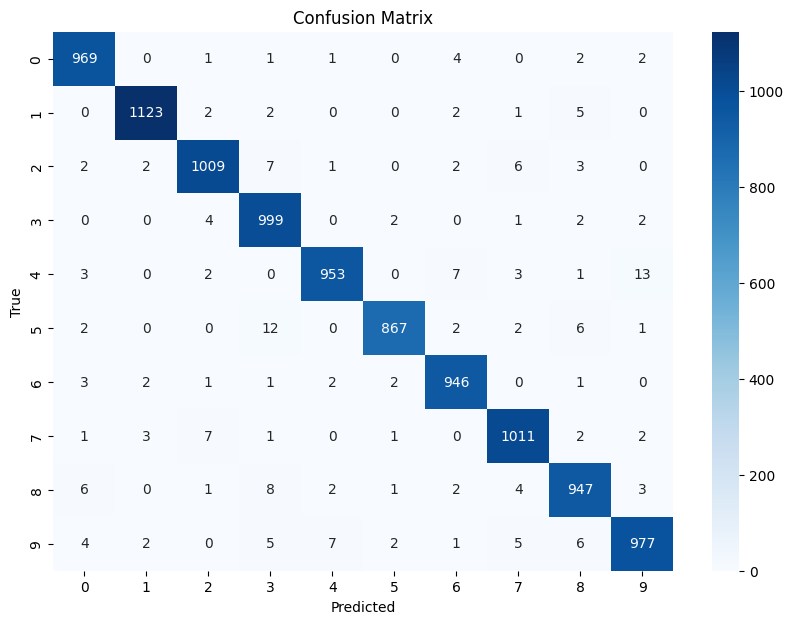

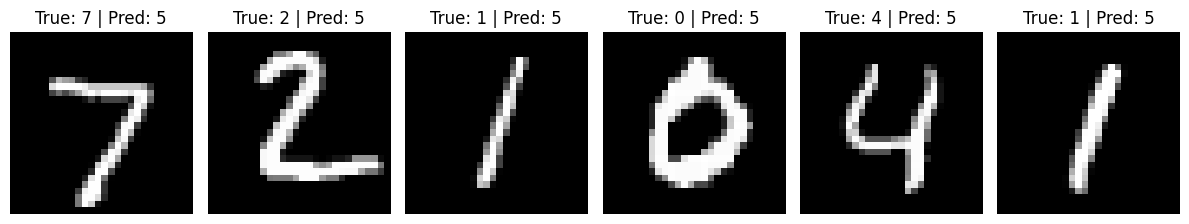

In [138]:
test(model_11, test_loader)

Three Layers with 512, 256, and 128 Neurons

Epoch [1/10]
Training Loss: 0.4420, Accuracy: 86.49%
Validation Loss: 0.1564, Accuracy: 95.14%
Epoch [2/10]
Training Loss: 0.1157, Accuracy: 96.46%
Validation Loss: 0.0902, Accuracy: 97.39%
Epoch [3/10]
Training Loss: 0.0751, Accuracy: 97.68%
Validation Loss: 0.0586, Accuracy: 98.30%
Epoch [4/10]
Training Loss: 0.0548, Accuracy: 98.25%
Validation Loss: 0.0410, Accuracy: 98.77%
Epoch [5/10]
Training Loss: 0.0393, Accuracy: 98.81%
Validation Loss: 0.0332, Accuracy: 99.04%
Epoch [6/10]
Training Loss: 0.0299, Accuracy: 99.08%
Validation Loss: 0.0261, Accuracy: 99.23%
Epoch [7/10]
Training Loss: 0.0238, Accuracy: 99.25%
Validation Loss: 0.0181, Accuracy: 99.48%
Epoch [8/10]
Training Loss: 0.0184, Accuracy: 99.43%
Validation Loss: 0.0116, Accuracy: 99.68%
Epoch [9/10]
Training Loss: 0.0150, Accuracy: 99.50%
Validation Loss: 0.0086, Accuracy: 99.81%
Epoch [10/10]
Training Loss: 0.0132, Accuracy: 99.56%
Validation Loss: 0.0106, Accuracy: 99.67%


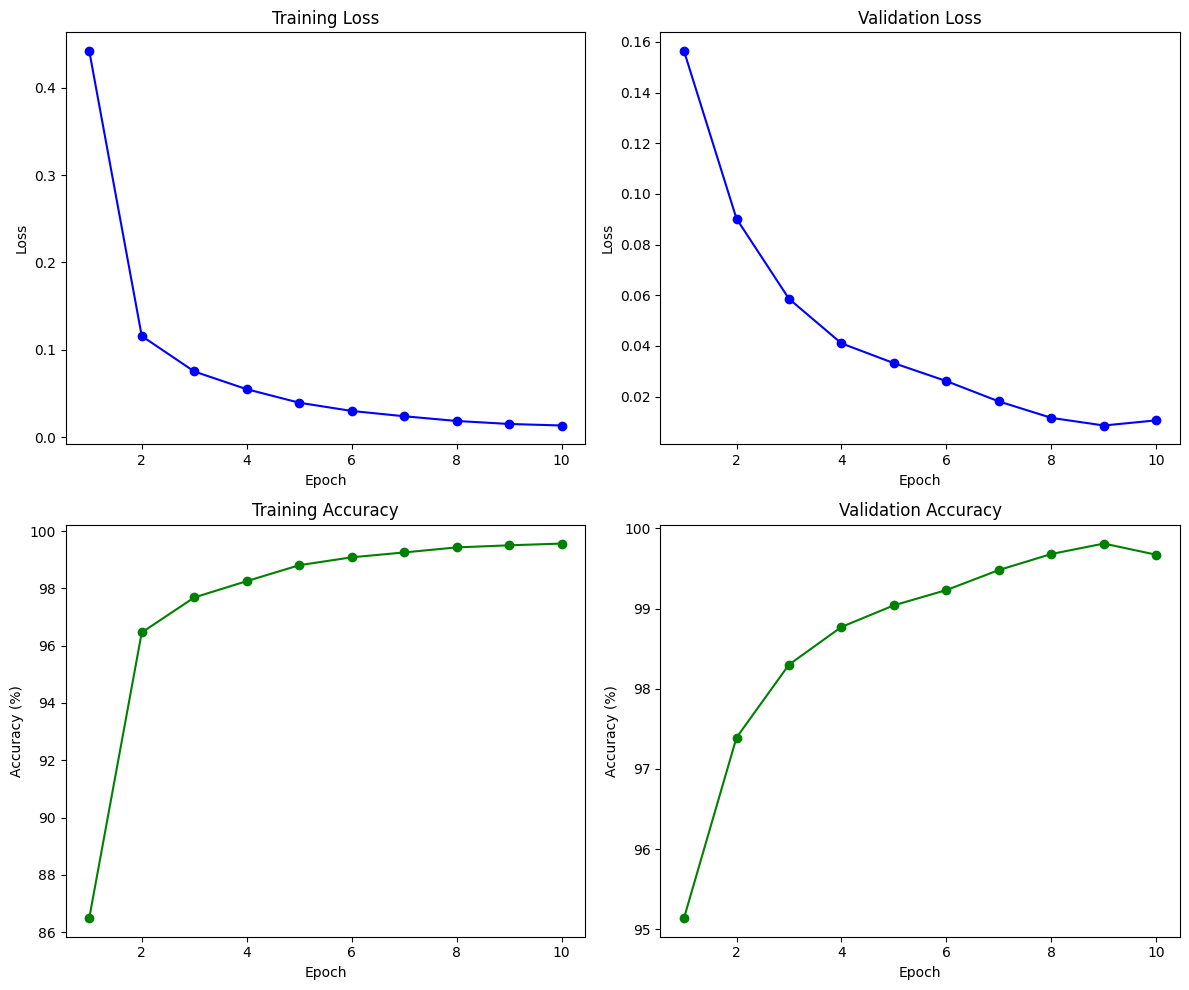

In [139]:
class FeedforwardNN_2(nn.Module):
    def __init__(self):
        super(FeedforwardNN_2, self).__init__()

        # Three layers with 512, 256, and 128 neurons
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.output(x)
        return x

model_12 = FeedforwardNN_2()
loss_fn_12 = nn.CrossEntropyLoss()
optimizer_12 = optim.SGD(model_12.parameters(), lr=0.1)

train(model_12, train_loader, val_loader, loss_fn_12, optimizer_12, 10)

Test Accuracy: 98.34%


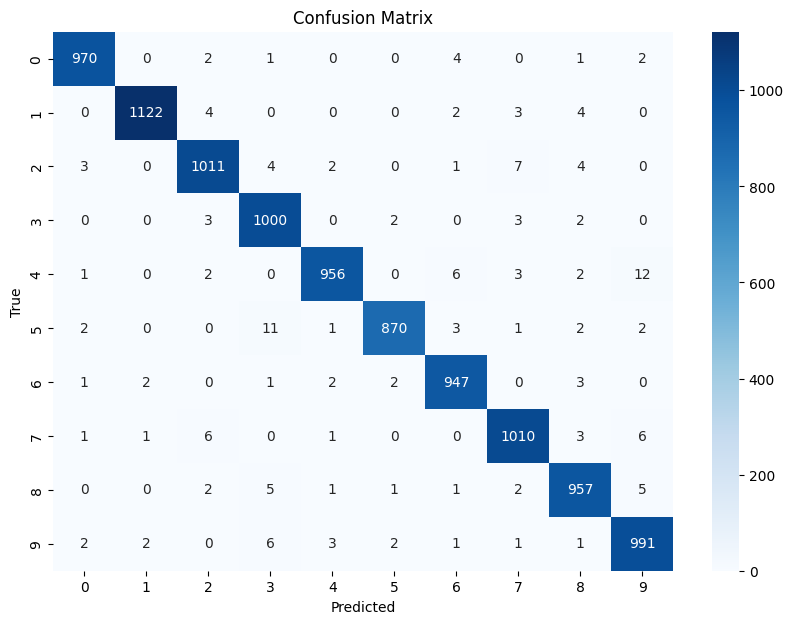

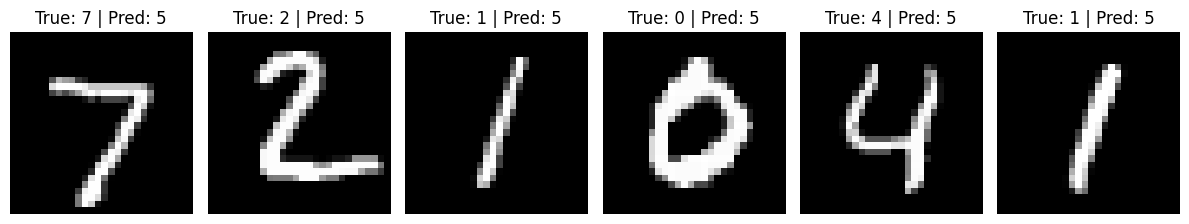

In [140]:
test(model_12, test_loader)

Four Layers with 512, 256, 128, and 64 Neurons

Epoch [1/10]
Training Loss: 0.6418, Accuracy: 78.46%
Validation Loss: 0.1689, Accuracy: 94.97%
Epoch [2/10]
Training Loss: 0.1220, Accuracy: 96.34%
Validation Loss: 0.0955, Accuracy: 97.19%
Epoch [3/10]
Training Loss: 0.0805, Accuracy: 97.52%
Validation Loss: 0.0606, Accuracy: 98.16%
Epoch [4/10]
Training Loss: 0.0588, Accuracy: 98.19%
Validation Loss: 0.0434, Accuracy: 98.76%
Epoch [5/10]
Training Loss: 0.0466, Accuracy: 98.51%
Validation Loss: 0.0360, Accuracy: 98.86%
Epoch [6/10]
Training Loss: 0.0348, Accuracy: 98.92%
Validation Loss: 0.0275, Accuracy: 99.15%
Epoch [7/10]
Training Loss: 0.0285, Accuracy: 99.11%
Validation Loss: 0.0217, Accuracy: 99.41%
Epoch [8/10]
Training Loss: 0.0218, Accuracy: 99.33%
Validation Loss: 0.0171, Accuracy: 99.45%
Epoch [9/10]
Training Loss: 0.0205, Accuracy: 99.35%
Validation Loss: 0.0233, Accuracy: 99.29%
Epoch [10/10]
Training Loss: 0.0155, Accuracy: 99.49%
Validation Loss: 0.0129, Accuracy: 99.61%


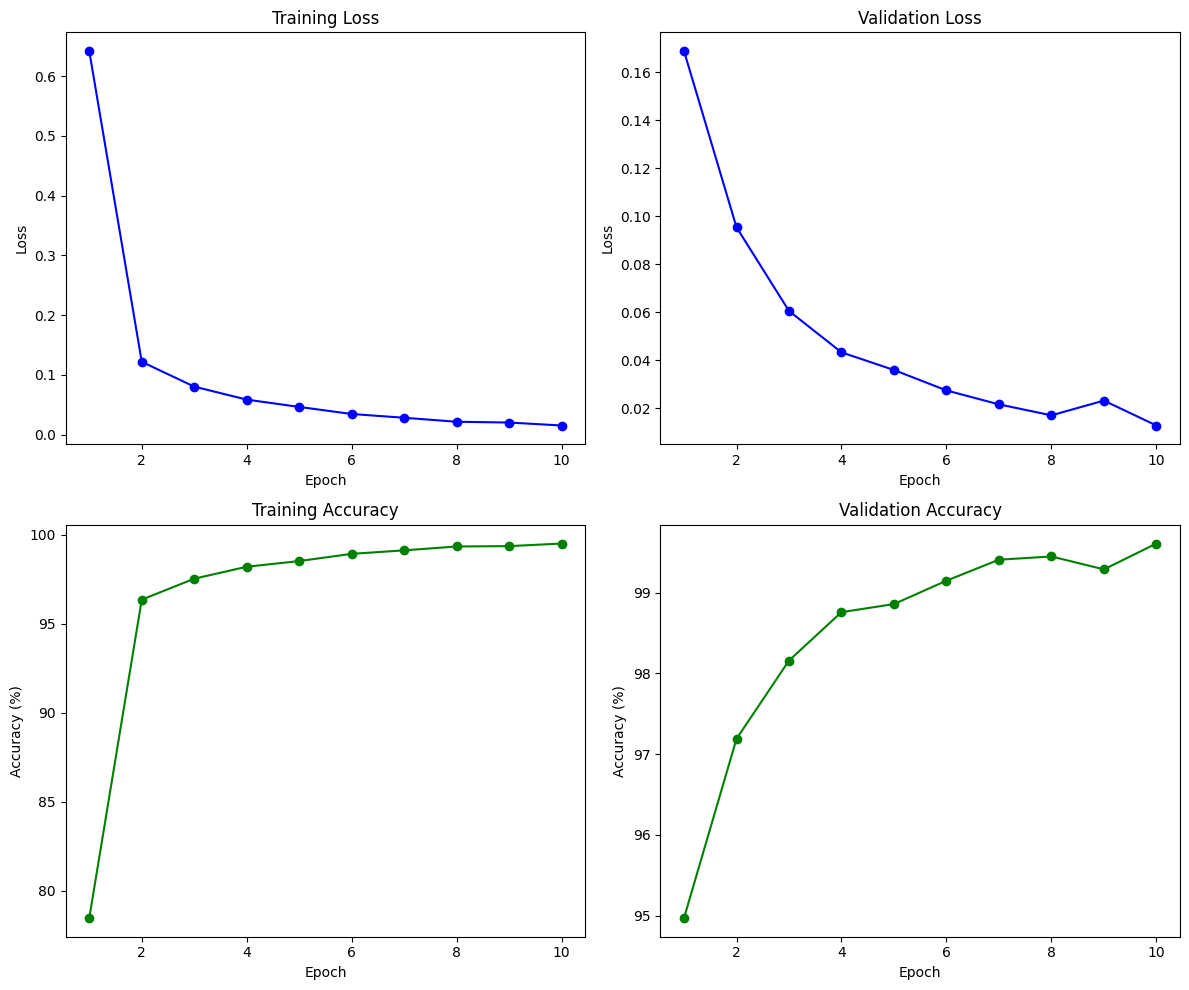

In [141]:
class FeedforwardNN_3(nn.Module):
    def __init__(self):
        super(FeedforwardNN_3, self).__init__()

        # Four layers with 512, 256, 128, and 64 neurons
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.activation_fn(self.l4(x))
        x = self.output(x)
        return x


model_13 = FeedforwardNN_3()
loss_fn_13 = nn.CrossEntropyLoss()
optimizer_13 = optim.SGD(model_13.parameters(), lr=0.1)

train(model_13, train_loader, val_loader, loss_fn_13, optimizer_13, 10)

Test Accuracy: 98.11%


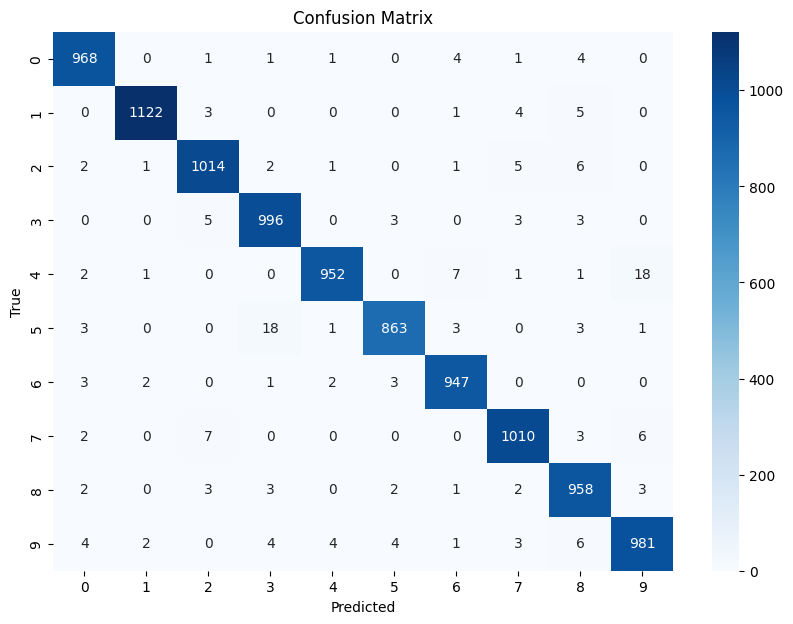

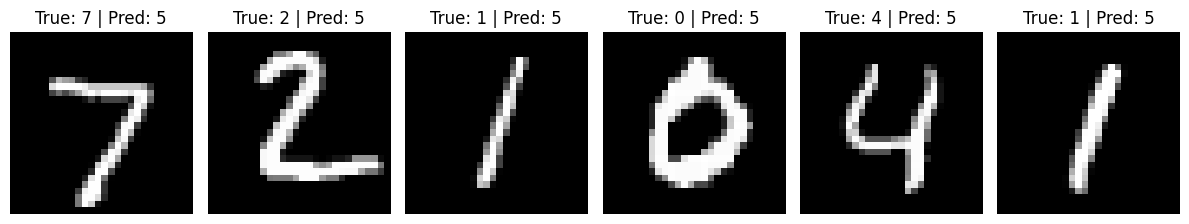

In [142]:
test(model_13, test_loader)

One Layer with 512 Neurons

Epoch [1/10]
Training Loss: 0.3558, Accuracy: 90.02%
Validation Loss: 0.2020, Accuracy: 94.14%
Epoch [2/10]
Training Loss: 0.1500, Accuracy: 95.70%
Validation Loss: 0.1264, Accuracy: 96.35%
Epoch [3/10]
Training Loss: 0.1027, Accuracy: 97.08%
Validation Loss: 0.0913, Accuracy: 97.38%
Epoch [4/10]
Training Loss: 0.0774, Accuracy: 97.72%
Validation Loss: 0.0711, Accuracy: 98.12%
Epoch [5/10]
Training Loss: 0.0622, Accuracy: 98.24%
Validation Loss: 0.0571, Accuracy: 98.51%
Epoch [6/10]
Training Loss: 0.0510, Accuracy: 98.61%
Validation Loss: 0.0475, Accuracy: 98.84%
Epoch [7/10]
Training Loss: 0.0423, Accuracy: 98.83%
Validation Loss: 0.0393, Accuracy: 99.04%
Epoch [8/10]
Training Loss: 0.0354, Accuracy: 99.01%
Validation Loss: 0.0320, Accuracy: 99.22%
Epoch [9/10]
Training Loss: 0.0304, Accuracy: 99.18%
Validation Loss: 0.0271, Accuracy: 99.43%
Epoch [10/10]
Training Loss: 0.0250, Accuracy: 99.39%
Validation Loss: 0.0227, Accuracy: 99.52%


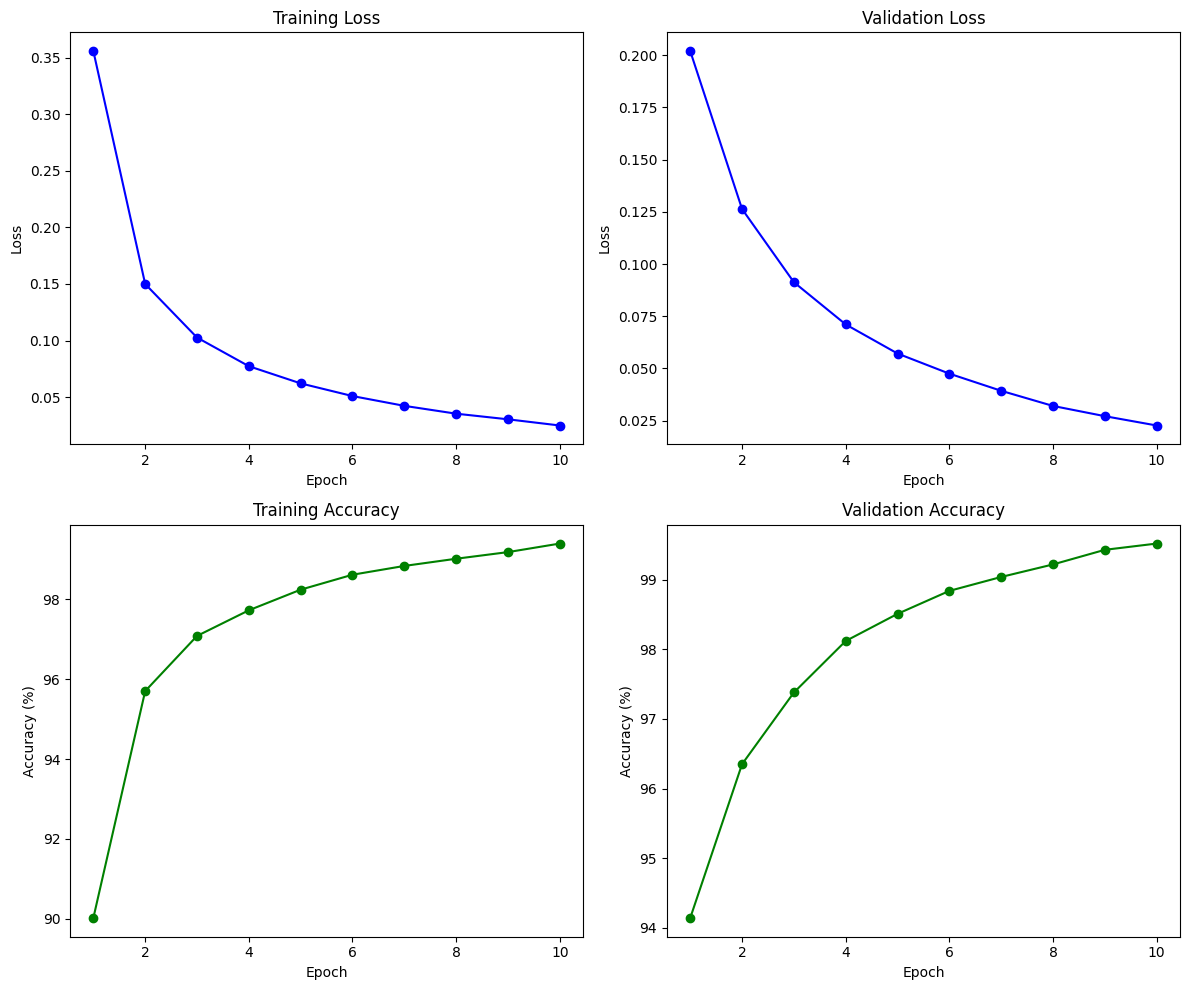

In [143]:
class FeedforwardNN_4(nn.Module):
    def __init__(self):
        super(FeedforwardNN_4, self).__init__()

        # One layer with 512 neurons
        self.l1 = nn.Linear(784, 512)
        self.output = nn.Linear(512, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.output(x)
        return x


model_14 = FeedforwardNN_4()
loss_fn_14 = nn.CrossEntropyLoss()
optimizer_14 = optim.SGD(model_14.parameters(), lr=0.1)

train(model_14, train_loader, val_loader, loss_fn_14, optimizer_14, 10)

Test Accuracy: 98.05%


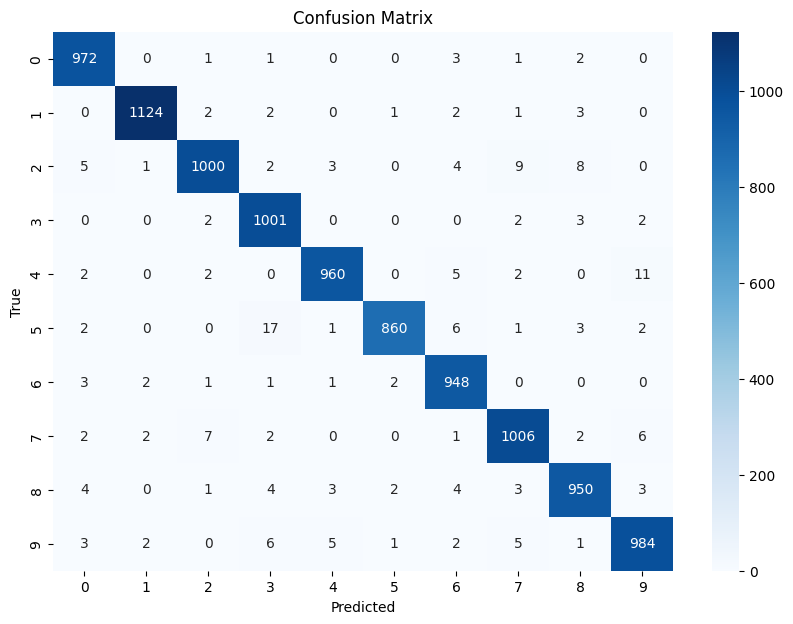

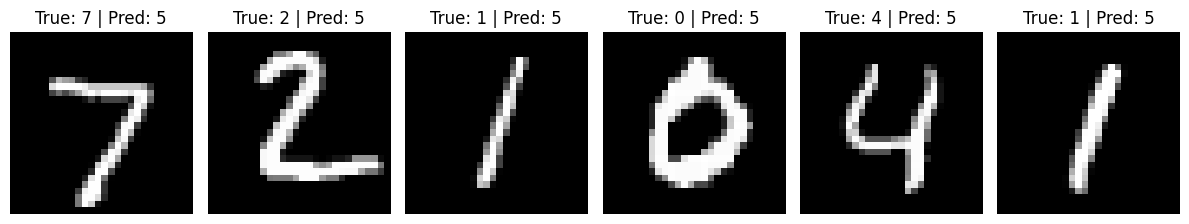

In [144]:
test(model_14, test_loader)

Two Layers with 256 and 128 Neurons

Epoch [1/10]
Training Loss: 0.3902, Accuracy: 88.61%
Validation Loss: 0.1747, Accuracy: 94.67%
Epoch [2/10]
Training Loss: 0.1284, Accuracy: 96.17%
Validation Loss: 0.1036, Accuracy: 96.69%
Epoch [3/10]
Training Loss: 0.0853, Accuracy: 97.37%
Validation Loss: 0.0684, Accuracy: 97.98%
Epoch [4/10]
Training Loss: 0.0627, Accuracy: 98.03%
Validation Loss: 0.0499, Accuracy: 98.59%
Epoch [5/10]
Training Loss: 0.0489, Accuracy: 98.47%
Validation Loss: 0.0373, Accuracy: 98.88%
Epoch [6/10]
Training Loss: 0.0378, Accuracy: 98.88%
Validation Loss: 0.0272, Accuracy: 99.31%
Epoch [7/10]
Training Loss: 0.0297, Accuracy: 99.09%
Validation Loss: 0.0204, Accuracy: 99.46%
Epoch [8/10]
Training Loss: 0.0238, Accuracy: 99.28%
Validation Loss: 0.0187, Accuracy: 99.49%
Epoch [9/10]
Training Loss: 0.0191, Accuracy: 99.42%
Validation Loss: 0.0131, Accuracy: 99.65%
Epoch [10/10]
Training Loss: 0.0127, Accuracy: 99.65%
Validation Loss: 0.0085, Accuracy: 99.80%


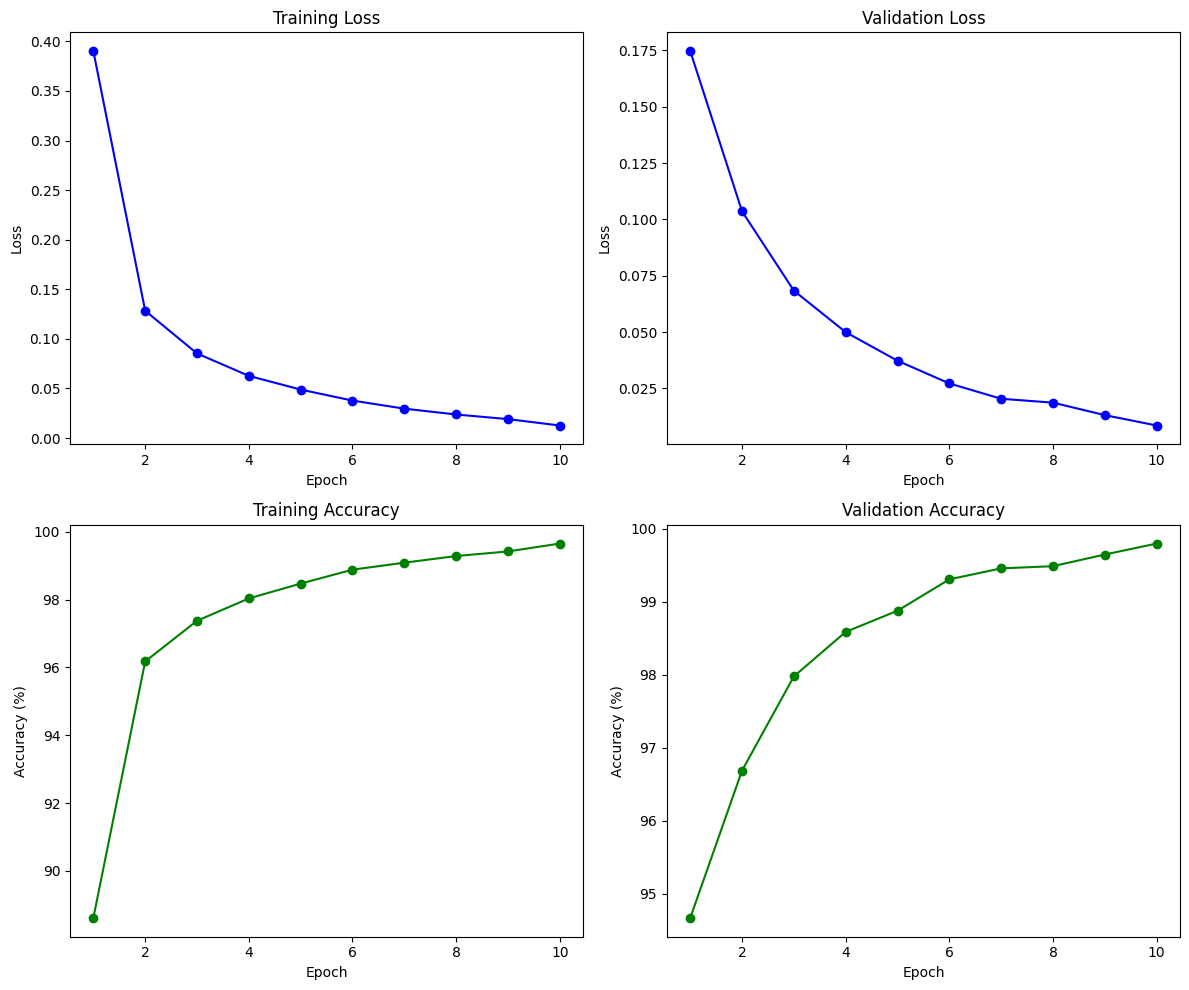

In [145]:
class FeedforwardNN_5(nn.Module):
    def __init__(self):
        super(FeedforwardNN_5, self).__init__()

        # Two layers with 256 and 128 neurons
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_15 = FeedforwardNN_5()
loss_fn_15 = nn.CrossEntropyLoss()
optimizer_15 = optim.SGD(model_15.parameters(), lr=0.1)

train(model_15, train_loader, val_loader, loss_fn_15, optimizer_15, 10)

Test Accuracy: 98.27%


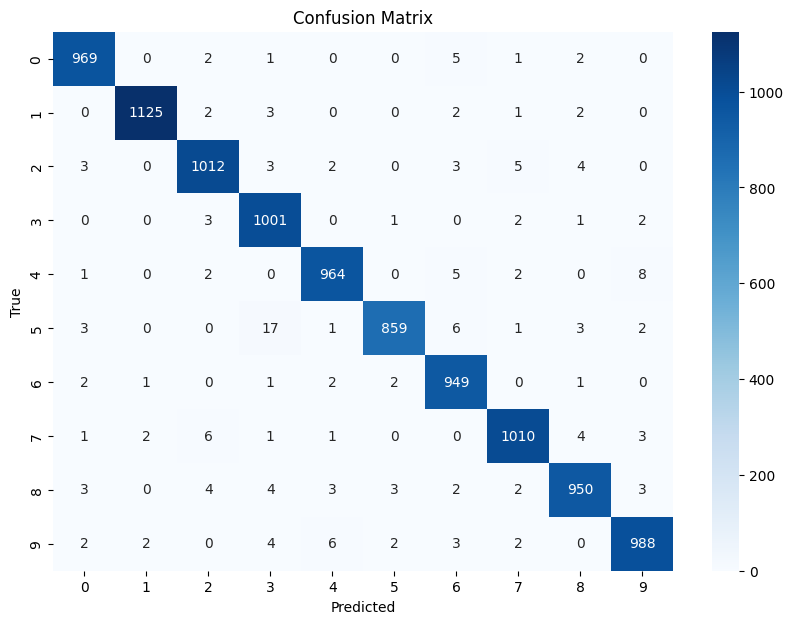

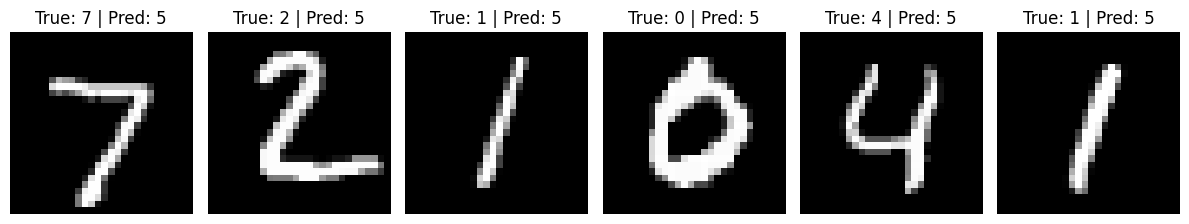

In [146]:
test(model_15, test_loader)

* At two layers with 128 and 64 Neurons --- Accuracy = **98.01%**
* At three layers with 512, 256, and 128 Neurons
 --- Accuracy = **98.34%**
* At four layers with 512, 256, 128, and 64 Neurons --- Accuracy = **98.11%**
* At one layer with 512 Neurons --- Accuracy = **98.05%**
* At two Layers with 256 and 128 Neurons --- Accuracy = **98.27%**

Then we choose At three layers with 512, 256, and 128 Neurons which is model_12 as it gives the highest accuracy

# Test of best found model on the test set

Test Accuracy: 98.34%


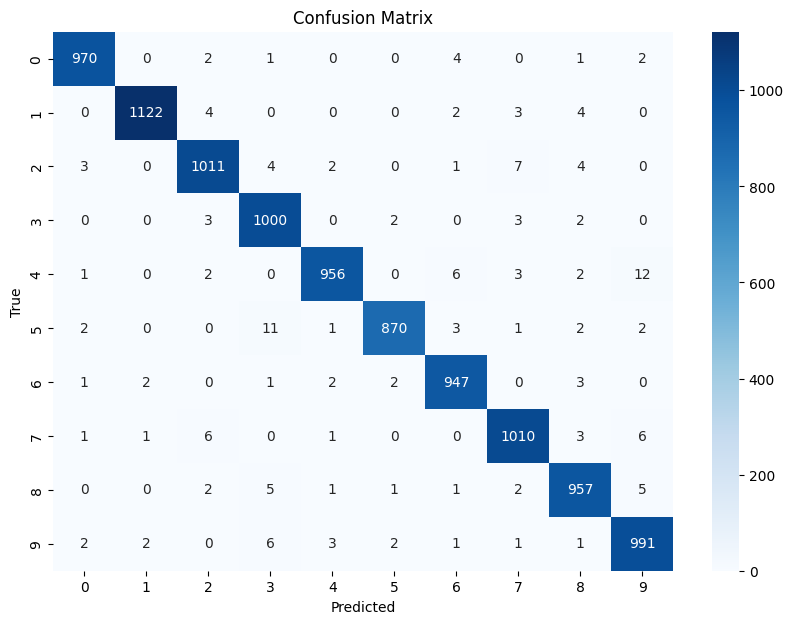

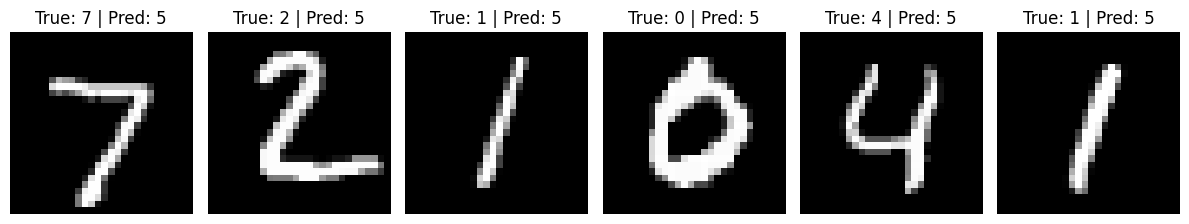

In [147]:
test(model_12, test_loader)